# First version of AE with clustering loss

## Import useful modules

In [1]:
!pip install scanpy
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip3 install igraph
!pip3 install leidenalg
!pip install os
!pip install csv

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement csv (from versions: none

In [2]:
from keras import layers
from keras.layers import Layer
from keras.models import load_model, Model
from keras import backend as K
from keras.losses import KLDivergence
import numpy as np
import scanpy as sc
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from layers import ConstantDispersionLayer, SliceLayer, ColWiseMultLayer
import keras
from keras.layers import Layer
from sklearn.model_selection import train_test_split
import datetime
import time
import os
import csv
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.metrics.pairwise import euclidean_distances

2024-06-14 08:32:23.143196: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 08:32:23.147269: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 08:32:23.198171: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 08:32:24.450195: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.__version__

'2.16.1'

In [4]:
keras.__version__

'3.3.3'

## Preprocessing

### Load dataset

On importe le dataset baron et on applique le prétraitement habituel

In [5]:
filename="./dataset/barondata_rawcounts.csv"
data_baron=pd.read_csv(filename, sep=';', comment="#", index_col=0)
data_baron

human1_lib1.final_cell_0001  human1_lib1.final_cell_0002  \
A1BG                              0                            0   
A1CF                              4                            0   
A2M                               0                            0   
A2ML1                             0                            0   
A4GALT                            0                            0   
...                             ...                          ...   
ZYG11B                            0                            1   
ZYX                               2                            4   
ZZEF1                             0                            0   
ZZZ3                              0                            1   
pk                                1                            0   

        human1_lib1.final_cell_0003  human1_lib1.final_cell_0004  \
A1BG                              0                            0   
A1CF                              0                            0   
A2M                               0                            0   
A2ML1                             0                            0   
A4GALT                            0                            0   
...                             ...                          ...   
ZYG11B                            0                            1   
ZYX                               0                            3   
ZZEF1                             0                            1   
ZZZ3                              0                            0   
pk                                0                            0   

        human1_lib1.final_cell_0005  human1_lib1.final_cell_0006  \
A1BG                              0                            0   
A1CF                              0                            1   
A2M                               0                            0   
A2ML1                             0                            0   
A4GALT                            0                            0   
...                             ...                          ...   
ZYG11B                            0                            0   
ZYX                               1                            1   
ZZEF1                             0                            1   
ZZZ3                              0                            1   
pk                                1                            0   

        human1_lib1.final_cell_0007  human1_lib1.final_cell_0008  \
A1BG                              0                            0   
A1CF                              0                            1   
A2M                               0                            0   
A2ML1                             0                            0   
A4GALT                            0                            0   
...                             ...                          ...   
ZYG11B                            1                            0   
ZYX                               1                            1   
ZZEF1                             0                            0   
ZZZ3                              1                            0   
pk                                0                            2   

        human1_lib1.final_cell_0009  human1_lib1.final_cell_0010  ...  \
A1BG                              0                            0  ...   
A1CF                              0                            0  ...   
A2M                               0                            0  ...   
A2ML1                             0                            0  ...   
A4GALT                            0                            0  ...   
...                             ...                          ...  ...   
ZYG11B                            0                            1  ...   
ZYX                               2                            0  ...   
ZZEF1                             1                            1  ...   
ZZZ3      

In [6]:
filename="./dataset/barondata_annotations.csv"
annotations_baron=pd.read_csv(filename, sep=';', comment="#", index_col=0)
annotations_baron

donor               label
human1_lib1.final_cell_0001  GSM2230757              acinar
human1_lib1.final_cell_0002  GSM2230757              acinar
human1_lib1.final_cell_0003  GSM2230757              acinar
human1_lib1.final_cell_0004  GSM2230757              acinar
human1_lib1.final_cell_0005  GSM2230757              acinar
...                                 ...                 ...
human4_lib3.final_cell_0697  GSM2230760  activated_stellate
human4_lib3.final_cell_0698  GSM2230760               alpha
human4_lib3.final_cell_0699  GSM2230760                beta
human4_lib3.final_cell_0700  GSM2230760                beta
human4_lib3.final_cell_0701  GSM2230760              ductal

[8569 rows x 2 columns]

In [7]:
data_ann=sc.AnnData(data_baron.T)
data_ann

AnnData object with n_obs × n_vars = 8569 × 20125

In [8]:
data_ann.obs['label'] = annotations_baron['label']

### Filter data

On filtre les données de manière peu stricte

In [9]:
sc.pp.filter_cells(data_ann, min_genes=1)
sc.pp.filter_genes(data_ann, min_cells=1)

In [10]:
data_ann.raw = data_ann.copy()

In [11]:
data_ann

AnnData object with n_obs × n_vars = 8569 × 17499
    obs: 'label', 'n_genes'
    var: 'n_cells'

### Normalize and scale

In [12]:
sc.pp.normalize_total(data_ann)
data_ann.obs['size_factors'] = data_ann.obs.n_genes / np.median(data_ann.obs.n_genes)
#data_ann.obs['size_factors'] = 1.0
sc.pp.log1p(data_ann)


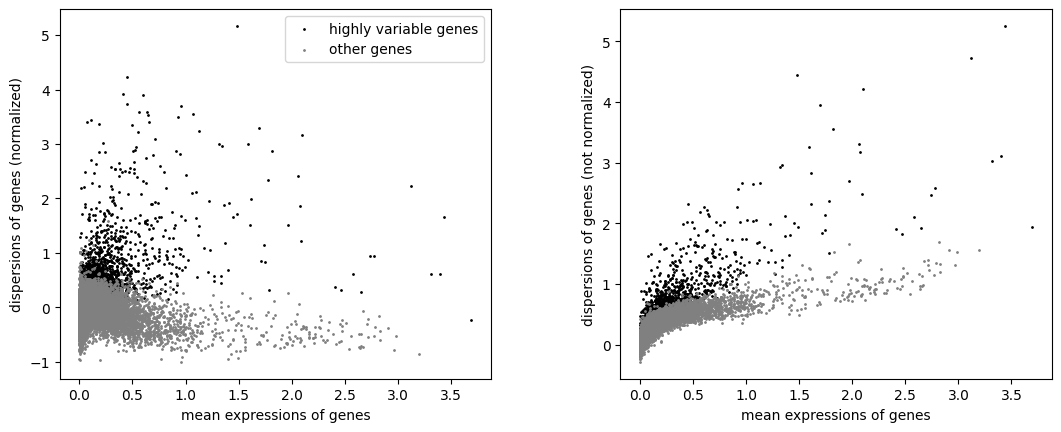

In [13]:
sc.pp.highly_variable_genes(data_ann, n_top_genes=2000, batch_key="label")
sc.pl.highly_variable_genes(data_ann)

In [14]:
sc.pp.scale(data_ann)

### Explore the result

In [15]:
data_ann.X

array([[-0.06469017,  1.563252  , -0.1655249 , ..., -0.37393612,
        -0.3080396 ,  0.31848672],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
         0.37840593, -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       ...,
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617]], dtype=float32)

In [16]:
data_ann.n_vars

17499

In [17]:
data_ann.X

array([[-0.06469017,  1.563252  , -0.1655249 , ..., -0.37393612,
        -0.3080396 ,  0.31848672],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
         0.37840593, -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       ...,
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617]], dtype=float32)

In [18]:
data_ann.var

n_cells  highly_variable     means  dispersions  dispersions_norm  \
A1BG         42            False  0.011018    -0.025517         -0.574290   
A1CF       1408            False  0.140704     0.230606         -0.024027   
A2M         273            False  0.162812     0.371500          0.196539   
A4GALT      444            False  0.134773     0.333580          0.060687   
AAAS       1216             True  0.183781     0.576148          0.473154   
...         ...              ...       ...          ...               ...   
ZYG11B     1394            False  0.192391     0.371347         -0.082705   
ZYX        2691            False  0.572281     0.582603         -0.147203   
ZZEF1      1225            False  0.144169     0.421400          0.217033   
ZZZ3        872            False  0.120500     0.381103          0.083912   
pk         1190             True  0.313284     0.762747          0.407774   

        highly_variable_nbatches  highly_variable_intersection      mean  \
A1BG                           1                         False  0.003199   
A1CF                           1                         False  0.132453   
A2M                            3                         False  0.029914   
A4GALT                         3                         False  0.043716   
AAAS                           6                         False  0.104913   
...                          ...                           ...       ...   
ZYG11B                         1                         False  0.119749   
ZYX                            2                         False  0.289623   
ZZEF1                          2                         False  0.106196   
ZZZ3                           1                         False  0.074865   
pk                             4                         False  0.107515   

             std  
A1BG    0.049455  
A1CF    0.327797  
A2M     0.180720  
A4GALT  0.203291  
AAAS    0.285008  
...          ...  
ZYG11B  0.299532  
ZYX     0.489316  
ZZEF1   0.283994  
ZZZ3    0.243036  
pk      0.303315  

[17499 rows x 9 columns]

In [19]:
data_ann.obs

label  n_genes  size_factors
human1_lib1.final_cell_0001              acinar     3526      1.909042
human1_lib1.final_cell_0002              acinar     4201      2.274499
human1_lib1.final_cell_0003              acinar     2119      1.147266
human1_lib1.final_cell_0004              acinar     2956      1.600433
human1_lib1.final_cell_0005              acinar     2715      1.469951
...                                         ...      ...           ...
human4_lib3.final_cell_0697  activated_stellate     1055      0.571197
human4_lib3.final_cell_0698               alpha     1007      0.545208
human4_lib3.final_cell_0699                beta      942      0.510016
human4_lib3.final_cell_0700                beta     1031      0.558202
human4_lib3.final_cell_0701              ductal      985      0.533297

[8569 rows x 3 columns]

In [20]:
data_ann.raw.X

array([[0, 4, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
highly_variable_genes = data_ann.var[data_ann.var['highly_variable']].index.tolist()
count_data_hvg = data_ann[:, highly_variable_genes].X
count_data_hvg=count_data_hvg.toarray()
count_data_hvg

array([[-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 ,  0.31848672],
       [-0.36810586,  0.04432194, -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586,  0.3338874 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       ...,
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617]], dtype=float32)

In [22]:
raw_count_hvg=data_ann.raw[:,highly_variable_genes].X

## Create autoencoder

In [23]:
def create_contrastive_encoder(input_dim, dims, dropout=0.8):
    Inputs = layers.Input(shape=(input_dim,))
    x = layers.Dropout(rate=dropout)(Inputs)  # L'argument input_shape n'est pas nécessaire ici
    for i in range(len(dims) - 1):
        x = layers.Dense(dims[i], kernel_initializer='glorot_uniform')(x)
        x = layers.BatchNormalization(epsilon=1e-5, momentum=0.1)(x)
        x = layers.ReLU()(x)
    
    # Dernière couche sans activation pour obtenir les embeddings
    x = layers.Dense(dims[-1],  kernel_initializer='glorot_uniform')(x)
    x = layers.Lambda(lambda y: tf.nn.l2_normalize(y, axis=1))(x)
    model = Model(Inputs, x)
    return model

In [24]:
def SupConLoss(features, labels=None, mask=None, temperature=0.07, base_temperature=0.07, contrast_mode='all'): 
    if len(features.shape) < 3:
        raise ValueError('`features` needs to be [bsz, n_views, ...], at least 3 dimensions are required')
    if len(features.shape) > 3:
        features = tf.reshape(features, [tf.shape(features)[0], tf.shape(features)[1], -1]) 
    batch_size = tf.shape(features)[0]
    if labels is not None and mask is not None:
        raise ValueError('Cannot define both `labels` and `mask`')
    elif labels is None and mask is None:
        mask = tf.eye(batch_size, dtype=tf.float32)
    elif labels is not None:
        labels = tf.reshape(labels, (-1, 1))
        if labels.shape[0] != batch_size:
            raise ValueError('Num of labels does not match num of features')
        mask = tf.cast(tf.equal(labels, tf.transpose(labels)), dtype=tf.float32)
    else:
        mask = tf.eye(batch_size, dtype=tf.float32)
    contrast_count = features.shape[1]
    contrast_feature = tf.reshape(tf.concat(tf.unstack(features, axis=1), axis=0), [-1, tf.shape(features)[2]])
    if contrast_mode == 'one':
        anchor_feature = features[:, 0]
        anchor_count = 1
    elif contrast_mode == "all":
        anchor_feature = contrast_feature
        anchor_count = contrast_count
    else:
        raise ValueError(f'Unknown mode : {contrast_mode}')
        
    anchor_dot_contrast = tf.math.divide(tf.linalg.matmul(anchor_feature, contrast_feature, transpose_b=True), temperature)
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    mask = tf.tile(mask, [anchor_count, contrast_count])
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size * anchor_count, dtype=tf.float32)
    mask *= logits_mask
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / tf.reduce_sum(mask, axis=1)

    loss = -(temperature / base_temperature) * mean_log_prob_pos
    loss = tf.reshape(loss, [anchor_count, batch_size])
    loss = tf.reduce_mean(loss)

    return loss

In [25]:
def auto_kmeans(encoder, x_counts, obs,n='auto',  plot=False):
    y=obs
    ari=[]
    nmi=[]
    ca=[]
    x=[]
    if n=="auto":
        for n in range (1,20):
            kmeans=KMeans(n_clusters=n, n_init=30, verbose=0)
            y_pred=kmeans.fit_predict(encoder.predict(x_counts, verbose=0))
            ari.append(adjusted_rand_score(y, y_pred))
            nmi.append(normalized_mutual_info_score(y, y_pred))
            ca.append(cluster_acc(y, y_pred))
            x.append(n)
        somme_metriques = [x + y + z for x, y, z in zip(ari, nmi, ca)]
        n=(somme_metriques.index(max(somme_metriques))+1)
    
    kmeans=KMeans(n_clusters=n, n_init=20)
    y_pred=kmeans.fit_predict(encoder.predict(x_counts))
    
    if plot==True:
        predict_data=encoder.predict(x_counts)
        adata_latent = sc.AnnData(predict_data)
        obs_df = pd.DataFrame({'label': y})
        adata_latent.obs=obs_df
        adata_latent.obs["kmeans"]=y_pred
        sc.pp.neighbors(adata_latent)
        sc.tl.umap(adata_latent)
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,ari)
        plt.plot(x,nmi)
        plt.plot(x,ca)
        plt.xlabel("nombre de clusters")
        plt.ylabel("Score")
        plt.legend(labels=["ARI", "NMI", "CA"])
        ari = adjusted_rand_score(y, y_pred)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, y_pred)
        print("Normalized mutual info (NMI) :", nmi)
        ca=cluster_acc(y, y_pred)
        print("Clustering accuracy (CA) :", ca)
        sc.pl.umap( adata_latent, color=["kmeans"], legend_loc="on data")
        plt.plot()
    return y_pred, n, kmeans.cluster_centers_

def auto_leiden(encoder, x_counts, y, res="auto", plot=False):
    predict_data=encoder.predict(x_counts, verbose=0)
    adata_latent = sc.AnnData(predict_data)
    obs_df = pd.DataFrame({'label': y})
    adata_latent.obs=obs_df
    sc.pp.neighbors(adata_latent, use_rep='X')
    sc.tl.umap(adata_latent)
    list_ari=[]
    list_nmi=[]
    list_ca=[]
    x=[]
    
    if res=="auto":
        #search for the best resolution
        for i in range (1,10):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            list_ca.append(cluster_acc(y, predict_cluster))
            x.append(i/100)
        for i in range (1,11):
            sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/10)
            predict_cluster=adata_latent.obs["leiden"]
            list_ari.append(adjusted_rand_score(y, predict_cluster))
            list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
            list_ca.append(cluster_acc(y, predict_cluster))
            x.append(i/10)
        somme_metriques = [x + y + z for x, y, z in zip(list_ari, list_nmi, list_ca)]
        res=x[somme_metriques.index(max(somme_metriques))]
        print("La résolution est de : ", res)
    #compute for the best resolution
    sc.tl.leiden(adata_latent, key_added="leiden_res_%.4f" % (res), resolution=res)
    predict=adata_latent.obs["leiden_res_%.4f" % (res)]
    
    
    #compute cluster center for initialization
    init_pred=np.asarray(predict,dtype=int)
    features=pd.DataFrame(adata_latent.X,index=np.arange(0,adata_latent.shape[0]))
    Group=pd.Series(init_pred,index=np.arange(0,adata_latent.shape[0]),name="Group")
    Mergefeature=pd.concat([features,Group],axis=1)
    cluster_centers=np.asarray(Mergefeature.groupby("Group").mean())
    n_clusters=len(np.unique(init_pred))
    
    #set of plot if required
    if plot==True:
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,list_ari)
        plt.plot(x,list_nmi)
        plt.plot(x,list_ca)
        plt.xlabel("nombre de clusters")
        plt.ylabel("Score")
        plt.legend(labels=["ARI", "NMI", "CA"])
        plt.plot()
        sc.pl.umap( adata_latent, color=["leiden_res_%.4f" % (res)], legend_loc="on data")
        ari = adjusted_rand_score(y, predict)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, predict)
        print("Normalized mutual info (NMI) :", nmi)
        ca=cluster_acc(y, predict)
        print("Clustering accuracy (CA) :", ca)
 
        #crosstab = pd.crosstab(predict,y)
        #sns.heatmap(crosstab, annot=True, cmap='Blues')
        #plt.ylabel('Clusters prédits')
        #plt.xlabel('Annotations réelles')
        #plt.title('Matrice de confusion')
        #plt.show()
    return res, predict, n_clusters, cluster_centers

def cluster_embedding(model, X, y, method=None, res='auto', n='auto', plot=False):
    if method=='leiden':
        res, predict, n_clusters, cluster_centers=auto_leiden(encoder=model, x_counts=X, y=y, res=res, plot=plot)
        return res, predict, n_clusters, cluster_centers
    elif method=='kmeans':
        y_pred, n_max, cluster_centers=auto_kmeans(encoder=model, x_counts=X, obs=y,n=n,  plot=plot)
        return res, y_pred, n_max, cluster_centers
    else:
        raise ValueError(f'Unknown method : {method}')
    

In [26]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = np.asarray(y_true)
   
    y_pred = np.asarray(y_pred)
    
    # Assurez-vous que les étiquettes sont de type str
    y_true= y_true.astype(str)
    y_pred = y_pred.astype(str)
    
    # Trouver les étiquettes uniques
    labels = np.unique(np.concatenate((y_true, y_pred)))
    n_labels = len(labels)

    # Construire la matrice de coût (matrice de confusion)
    cost_matrix = np.zeros((n_labels, n_labels), dtype=int)
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            cost_matrix[i, j] = np.sum((y_true == label_true) & (y_pred == label_pred))

    # Résoudre le problème de correspondance bipartite optimal
    row_ind, col_ind = linear_assignment(cost_matrix.max() - cost_matrix)

    # Calculer la précision
    accuracy = np.sum([cost_matrix[i, j] for i, j in zip(row_ind, col_ind)]) / y_true.size

    return accuracy


In [27]:
def save_results_to_csv(history, filename):
    file_exists = os.path.isfile(filename)
    with open(filename, mode='a') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(history.keys())
        writer.writerow(history.values())
        
def check_existing_filename(filename):
    base, ext = os.path.splitext(filename)
    counter = 1
    while os.path.exists(filename):
        filename = f"{base}_{counter}{ext}"
        counter += 1
    return filename

def save_plot_umap(model, x, y, y_pred, res, epoch, pdf_pages, train_val="train"):
    #Récupération des données et projection dans l'espace latent 
    predict_data=model.predict(x, verbose=0)
    obs_df = pd.DataFrame({'label': y})
    
    #Préparation des données pour Scanpy
    adata_latent = sc.AnnData(X=predict_data)
    adata_latent.obs = obs_df
    adata_latent.obs['predict'] = y_pred.astype(str)

    sc.pp.neighbors(adata_latent, use_rep='X')
    sc.tl.umap(adata_latent)
    
    # Génération du UMAP avec Scanpy
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sc.pl.umap(adata_latent, color='label', ax=axs[0], show=False)
    axs[0].set_title(f'UMAP projection - Labels ({train_val}) (Res: {res}, Iter: {epoch})')
    sc.pl.umap(adata_latent, color='predict', ax=axs[1], show=False)
    axs[1].set_title(f'UMAP projection - Predictions ({train_val}) (Res: {res}, Iter: {epoch})')

    pdf_pages.savefig(fig)
    plt.close(fig)

In [28]:
def split(x_counts, y):
    train_idx, temp_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
    x_train=x_counts[train_idx]
    x_val=x_counts[val_idx]
    x_test=x_counts[test_idx]
    y_train=y[train_idx]
    y_val=y[val_idx]
    y_test=y[test_idx]
    print("Size of train set : ", x_train.shape)
    print("Size of val set : ", x_val.shape)
    print("Size of test set : ", x_test.shape)
    return x_train, x_val, x_test, y_train, y_val, y_test

In [29]:
x_train, x_val, x_test, y_train, y_val, y_test = split(count_data_hvg, data_ann.obs['label'])

Size of train set :  (5998, 2000)
Size of val set :  (1285, 2000)
Size of test set :  (1286, 2000)


/tmp/ipykernel_2220163/1861979137.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
/tmp/ipykernel_2220163/1861979137.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=y[train_idx]
/tmp/ipykernel_2220163/1861979137.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=y[val_idx]
/tmp/ipykernel_2220163/1861979137.py:9:

In [30]:
def train_model(X, Y=None, n='auto', res='auto', nb_epochs=30, lr=0.4, 
                temperature=0.07, dropout=0.9, evaluate_training=False, eval_interval=1, 
                layers=[200, 40, 60], save=False, noise=0, method='leiden', batch_size=200, 
               X_test=None, Y_test=None, early_stopping=False, plot_loss=False):
    dims = [X.shape[1]]+layers
    model= create_contrastive_encoder(input_dim=X.shape[1], dims=layers, dropout=dropout)
    model.summary()
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
    val_losses=[]
    losses=[]
    idx=np.arange(len(X))
    idx_test=np.arange(len(X_test))
    
    #Création du dictionnaire pour le monitoring
    history={
        "dropout": dropout,
        "noise": noise, 
        "lr": lr,
        "NMI" :[],
        "ARI" :[],
        "CA" :[],
        "val_NMI":[],
        "val_ARI":[],
        "val_CA":[],
        "loss":[],
        "val_loss":[]
    }
    
    if save:
        #initiate pdf files
        pdf_filename_train = 'data/contrastive-sc/res/plots/plots_train__res_%.4f.pdf' % res
        #pdf_filename_train = check_existing_filename(pdf_filename_train)
        pdf_pages_train = PdfPages(pdf_filename_train)
    
        pdf_filename_test = 'data/contrastive-sc/res/plots/plots_val_res_%.4f.pdf' % res
        #pdf_filename_test = check_existing_filename(pdf_filename_test)
        pdf_pages_test = PdfPages(pdf_filename_test)
    
    for epoch in range (nb_epochs):
        np.random.shuffle(idx)
        np.random.shuffle(idx_test)
        loss_=0
        val_loss_=0
        for pre_index in range (len(X)//batch_size+1):
            c_idx=np.arange(pre_index*batch_size, min(len(X), (pre_index+1)*batch_size))
            if len(c_idx)==0:
                continue
            c_idx=idx[c_idx]
            c_inp=X[c_idx]
            if noise is None or noise == 0 :
                input1=tf.convert_to_tensor(c_inp, dtype=tf.float32)
                input2=tf.convert_to_tensor(c_inp, dtype=tf.float32)
            else : 
                noise_vec = np.random.normal(loc=0, scale=noise, size=c_inp.shape)
                input1 = tf.convert_to_tensor(c_inp + noise_vec, dtype=tf.float32)
                noise_vec = np.random.normal(loc=0, scale=noise, size=c_inp.shape)
                input2 = tf.convert_to_tensor(c_inp + noise_vec, dtype=tf.float32)
            
            with tf.GradientTape() as tape :
                anchors_output=model(input1,  training=True)
                neighbors_output=model(input2,  training=True)
                features = tf.stack([anchors_output, neighbors_output], axis=1)
                total_loss= SupConLoss(features=features, temperature=temperature)
                loss_+=total_loss.numpy()
            
            gradients = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        print(f"{epoch}). Loss : {loss_}")
        
        if epoch % eval_interval == 0:
            if evaluate_training and Y is not None :
                #result = model.predict(X)
                res_i, result, n_cluster, cluster_centers =cluster_embedding(model, X, Y, method=method, res=res, n=n, plot=False)
                ca=np.round(cluster_acc(Y, result), 5)
                nmi=np.round(normalized_mutual_info_score(Y, result), 5)
                ari=np.round(adjusted_rand_score(Y, result), 5)
                print( f"ARI {ari}, NMI: {nmi}, CA : {ca}, clusters : {n_cluster}")
                history["NMI"].append(nmi)
                history["ARI"].append(ari)
                history["CA"].append(ca)
                #save a plot
                save_plot_umap(model, X, Y, result, res_i, epoch, pdf_pages_train, "train")
            
        #to obtain test value if train test split
        if X_test is not None : 
            for pre_index_test in range (len(X_test)//batch_size+1):
                c_idx_test=np.arange(pre_index_test*batch_size, min(len(X_test), (pre_index_test+1)*batch_size))
                if len(c_idx_test)==0:
                    continue
                c_idx_test=idx_test[c_idx_test]
                c_inp_test=X_test[c_idx_test]
                if noise is None or noise == 0 :
                    input1_test=tf.convert_to_tensor(c_inp_test, dtype=tf.float32)
                    input2_test=tf.convert_to_tensor(c_inp_test, dtype=tf.float32)
                else : 
                    noise_vec_test = np.random.normal(loc=0, scale=noise, size=c_inp_test.shape)
                    input1_test = tf.convert_to_tensor(c_inp_test + noise_vec_test, dtype=tf.float32)
                    noise_vec_test = np.random.normal(loc=0, scale=noise, size=c_inp_test.shape)
                    input2_test = tf.convert_to_tensor(c_inp_test + noise_vec_test, dtype=tf.float32)
            
                with tf.GradientTape() as tape :
                    anchors_output_test=model(input1_test,  training=True)
                    neighbors_output_test=model(input2_test,  training=True)
                    features_test = tf.stack([anchors_output_test, neighbors_output_test], axis=1)
                    total_val_loss= SupConLoss(features=features_test, temperature=temperature)
                    val_loss_+=total_val_loss.numpy()
        print(f"val_loss : {val_loss_}")
        
        if epoch % eval_interval == 0:
            if evaluate_training and Y_test is not None :
                test_embedding=model.predict(X_test, verbose=0)
                distances=euclidean_distances(test_embedding, cluster_centers)
                test_clusters=np.argmin(distances, axis=1)
                val_ca=np.round(cluster_acc(Y_test, test_clusters), 5)
                val_nmi=np.round(normalized_mutual_info_score(Y_test, test_clusters), 5)
                val_ari=np.round(adjusted_rand_score(Y_test, test_clusters), 5)
                print( f"val_ARI {val_ari}, val_NMI: {val_nmi}, val_CA : {val_ca}")
                history["val_NMI"].append(val_nmi)
                history["val_ARI"].append(val_ari)
                history["val_CA"].append(val_ca)
                save_plot_umap(model, X_test, Y_test, test_clusters, res_i, epoch, pdf_pages_test, "val")
            
        
        losses.append(loss_)
        val_losses.append(val_loss_)
        

        
        if early_stopping and X_test is not None:
            indice_max=val_losses.index(min(val_losses))
            if abs(indice_max-len(val_losses)-1)>5:
                break
            
    if plot_loss:
        x=[i for i in range (len(losses))]
        plt.plot(x, losses)
        plt.plot(x, val_losses)
        plt.legend(labels=['loss', 'val loss'])
        plt.plot()
    
    history["loss"]=losses
    history["val_loss"]=val_losses
    
    res, result, n_cluster, cluster_centers=cluster_embedding(model, X, Y, method=method, res=res, n=n, plot=True)
    
    if save==True and Y is not None :
        history["res"]=res
        history["clusters"]=n_cluster
        history['NMI final']=nmi
        history['ARI final']=ari
        history['CA final']=ca
    if save==True and Y_test is not None :
        history['val_NMI final']=val_nmi
        history['val_ARI final']=val_ari
        history['val_CA final']=val_ca
    if save:
        #save dictionnary
        save_results_to_csv(history, "data/contrastive-sc/res/contrastive_sc_res.csv")
        pdf_pages_train.close()
        pdf_pages_test.close()
    return model, result

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 172.93605089187622


/tmp/ipykernel_2220163/1926420529.py:78: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_latent, key_added="leiden_res_%.4f" % (res), resolution=res)


ARI 0.3045, NMI: 0.48129, CA : 0.507, clusters : 4
val_loss : 36.743834495544434
val_ARI 0.32748, val_NMI: 0.48981, val_CA : 0.50117
1). Loss : 156.22666883468628
ARI 0.32007, NMI: 0.49162, CA : 0.5035, clusters : 4
val_loss : 34.96177101135254
val_ARI 0.30879, val_NMI: 0.49115, val_CA : 0.52218
2). Loss : 150.65313291549683
ARI 0.74426, NMI: 0.75777, CA : 0.80794, clusters : 5
val_loss : 33.94422388076782
val_ARI 0.66098, val_NMI: 0.71128, val_CA : 0.78054
3). Loss : 144.7341504096985
ARI 0.76702, NMI: 0.78263, CA : 0.81427, clusters : 5
val_loss : 32.17557096481323
val_ARI 0.77009, val_NMI: 0.77211, val_CA : 0.81634
4). Loss : 139.10528469085693
ARI 0.77454, NMI: 0.79204, CA : 0.81761, clusters : 5
val_loss : 31.27470874786377
val_ARI 0.77513, val_NMI: 0.7752, val_CA : 0.81634
5). Loss : 135.5116901397705
ARI 0.7707, NMI: 0.79907, CA : 0.81644, clusters : 5
val_loss : 30.60686755180359
val_ARI 0.77565, val_NMI: 0.78012, val_CA : 0.82023
6). Loss : 132.70011568069458
ARI 0.78566, NMI:

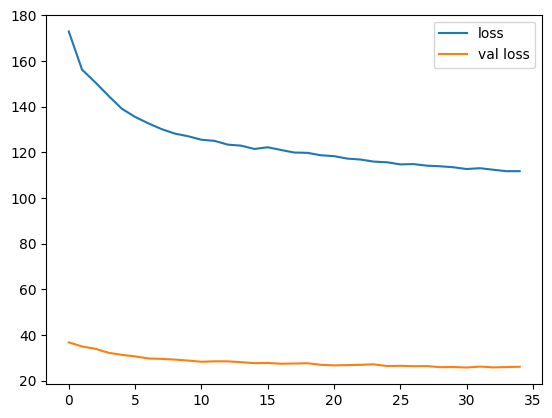

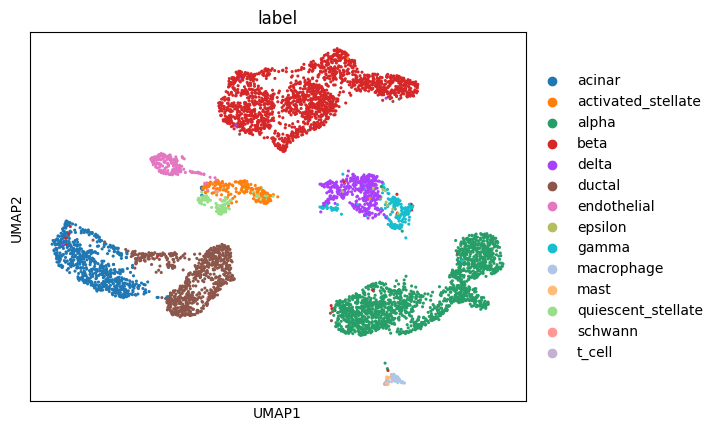

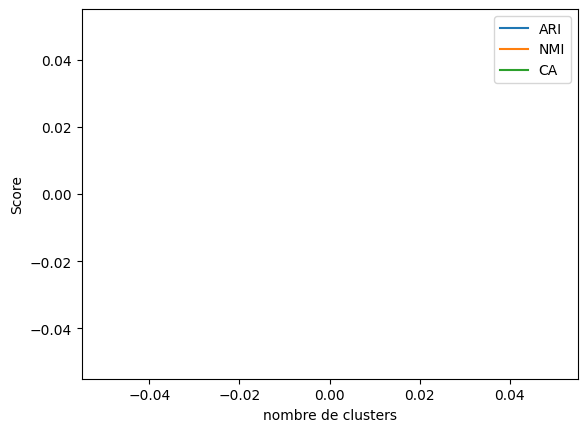

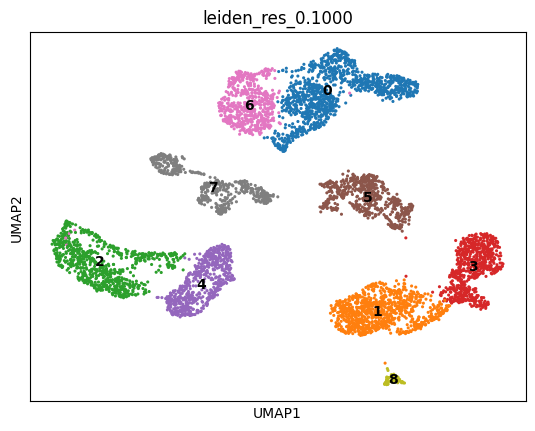

Indice de Rand ajusté (ARI) : 0.6526973616467029
Normalized mutual info (NMI) : 0.8024364074693842
Clustering accuracy (CA) : 0.6773924641547182


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 173.50986003875732
ARI 0.33919, NMI: 0.50138, CA : 0.52634, clusters : 4
val_loss : 36.57593011856079
val_ARI 0.33425, val_NMI: 0.49244, val_CA : 0.5323
1). Loss : 155.90218830108643
ARI 0.35511, NMI: 0.52652, CA : 0.53068, clusters : 4
val_loss : 34.819475173950195
val_ARI 0.35009, val_NMI: 0.51405, val_CA : 0.56732
2). Loss : 151.0031294822693
ARI 0.71543, NMI: 0.74048, CA : 0.7976, clusters : 5
val_loss : 34.0870566368103
val_ARI 0.67891, val_NMI: 0.71046, val_CA : 0.78366
3). Loss : 145.50815963745117
ARI 0.7574, NMI: 0.76634, CA : 0.8111, clusters : 5
val_loss : 32.21016573905945
val_ARI 0.76728, val_NMI: 0.77487, val_CA : 0.81634
4). Loss : 140.3303394317627
ARI 0.76565, NMI: 0.78164, CA : 0.81294, clusters : 5
val_loss : 31.70978879928589
val_ARI 0.77958, val_NMI: 0.78914, val_CA : 0.81946
5). Loss : 137.7786808013916
ARI 0.76886, NMI: 0.79565, CA : 0.81444, clusters : 5
val_loss : 31.28670358657837
val_ARI 0.77177, val_NMI: 0.775, val_CA : 0.81634
6). Loss : 134.9783

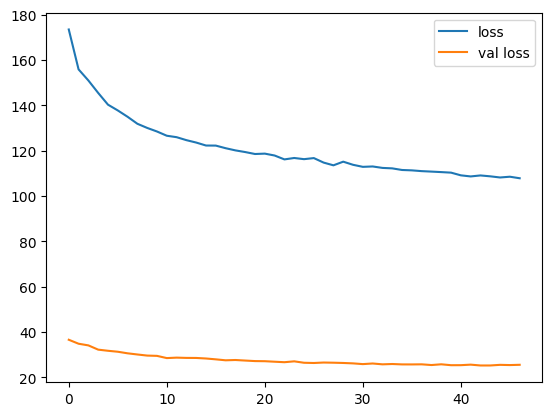

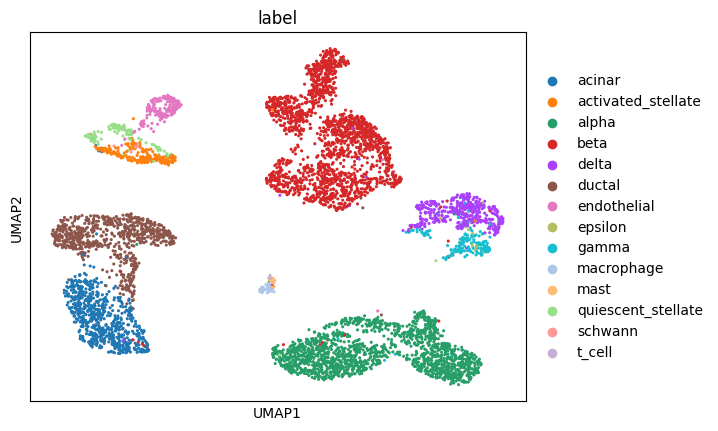

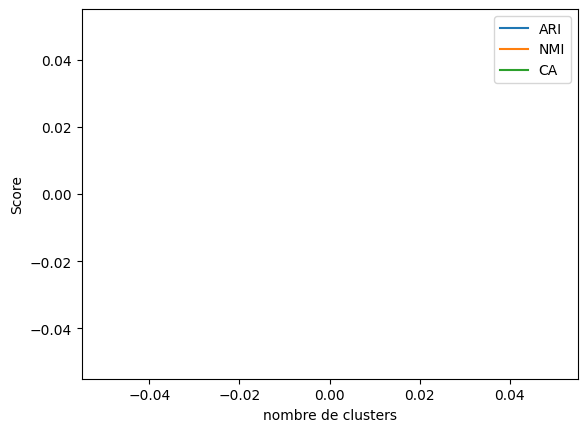

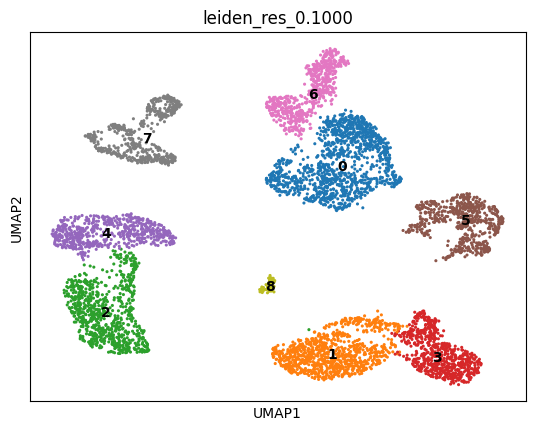

Indice de Rand ajusté (ARI) : 0.6460372892667008
Normalized mutual info (NMI) : 0.795884024940318
Clustering accuracy (CA) : 0.6728909636545515


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 168.7195553779602
ARI 0.32104, NMI: 0.46614, CA : 0.42097, clusters : 3
val_loss : 36.57448196411133
val_ARI 0.32264, val_NMI: 0.45712, val_CA : 0.43268
1). Loss : 155.61138439178467
ARI 0.67203, NMI: 0.69195, CA : 0.76592, clusters : 4
val_loss : 34.18864297866821
val_ARI 0.6996, val_NMI: 0.69653, val_CA : 0.76109
2). Loss : 146.0288119316101
ARI 0.76258, NMI: 0.77351, CA : 0.8136, clusters : 5
val_loss : 32.5847282409668
val_ARI 0.76441, val_NMI: 0.76488, val_CA : 0.81167
3). Loss : 140.78010272979736
ARI 0.87905, NMI: 0.83093, CA : 0.87396, clusters : 6
val_loss : 31.726327657699585
val_ARI 0.84331, val_NMI: 0.79464, val_CA : 0.85292
4). Loss : 138.4388885498047
ARI 0.89063, NMI: 0.84019, CA : 0.87813, clusters : 6
val_loss : 31.27536916732788
val_ARI 0.86112, val_NMI: 0.81686, val_CA : 0.86226
5). Loss : 135.74987411499023
ARI 0.77515, NMI: 0.80042, CA : 0.81744, clusters : 5
val_loss : 30.76931595802307
val_ARI 0.76712, val_NMI: 0.76512, val_CA : 0.8179
6). Loss : 133.4

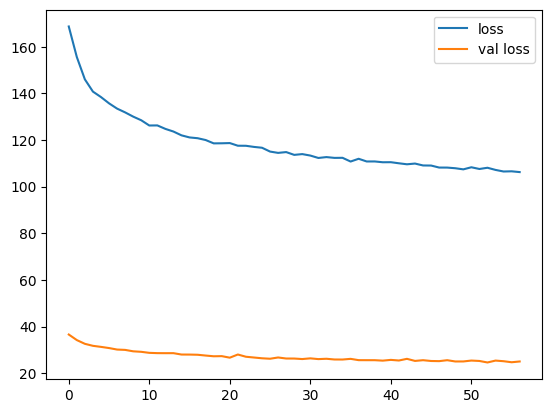

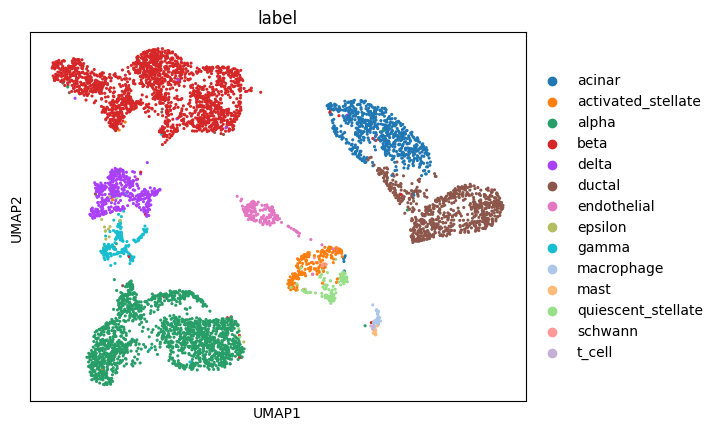

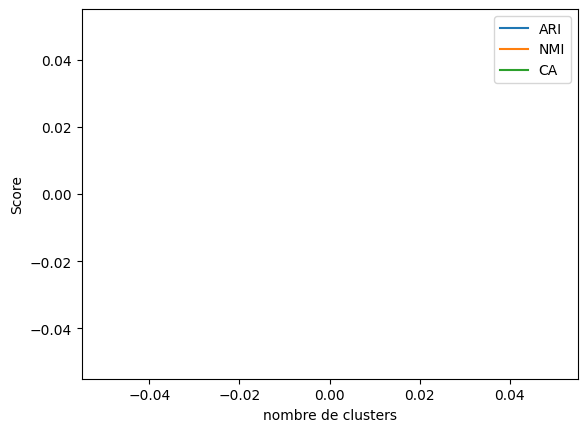

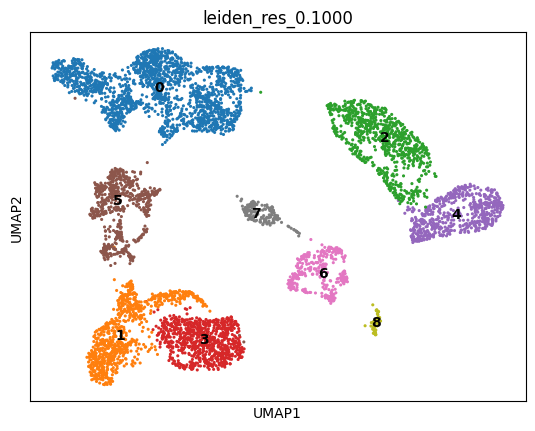

Indice de Rand ajusté (ARI) : 0.8030727183029281
Normalized mutual info (NMI) : 0.8522398905043881
Clustering accuracy (CA) : 0.7794264754918306


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 168.67736101150513
ARI 0.33367, NMI: 0.4931, CA : 0.57336, clusters : 4
val_loss : 35.60741853713989
val_ARI 0.33623, val_NMI: 0.49424, val_CA : 0.56265
1). Loss : 153.54000902175903
ARI 0.74276, NMI: 0.74523, CA : 0.8066, clusters : 5
val_loss : 34.253634452819824
val_ARI 0.61746, val_NMI: 0.67703, val_CA : 0.76187
2). Loss : 146.4737319946289
ARI 0.77259, NMI: 0.78635, CA : 0.81711, clusters : 5
val_loss : 32.37499642372131
val_ARI 0.77039, val_NMI: 0.76424, val_CA : 0.81401
3). Loss : 140.4035210609436
ARI 0.77862, NMI: 0.79214, CA : 0.81861, clusters : 5
val_loss : 31.66743040084839
val_ARI 0.76983, val_NMI: 0.76843, val_CA : 0.81245
4). Loss : 136.893470287323
ARI 0.71691, NMI: 0.75845, CA : 0.76109, clusters : 6
val_loss : 31.063494443893433
val_ARI 0.68077, val_NMI: 0.7276, val_CA : 0.70739
5). Loss : 135.65009021759033
ARI 0.70913, NMI: 0.75319, CA : 0.74208, clusters : 6
val_loss : 30.614723920822144
val_ARI 0.68705, val_NMI: 0.7271, val_CA : 0.72296
6). Loss : 132.

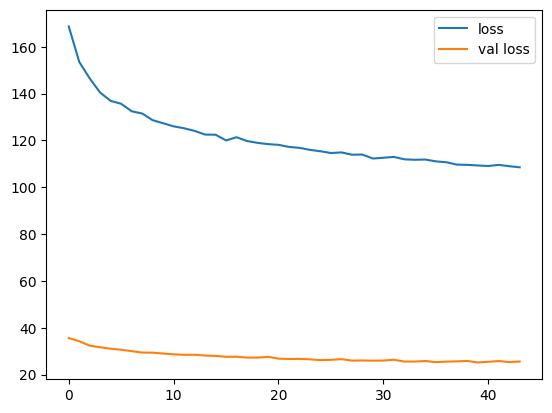

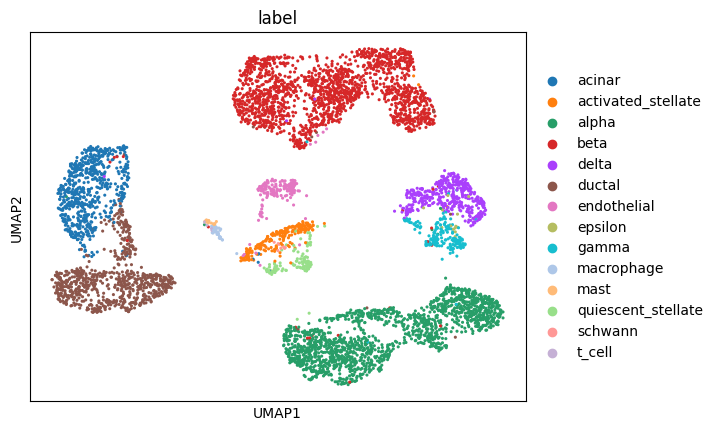

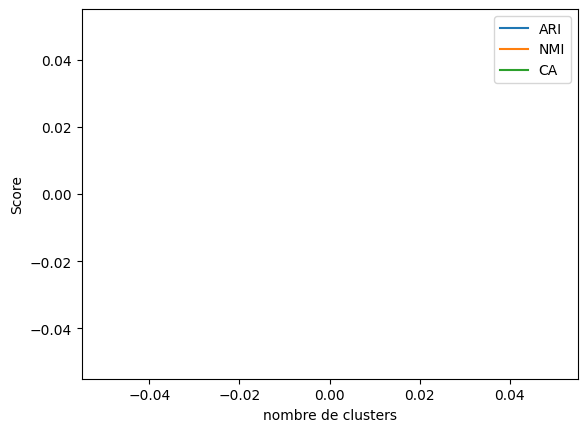

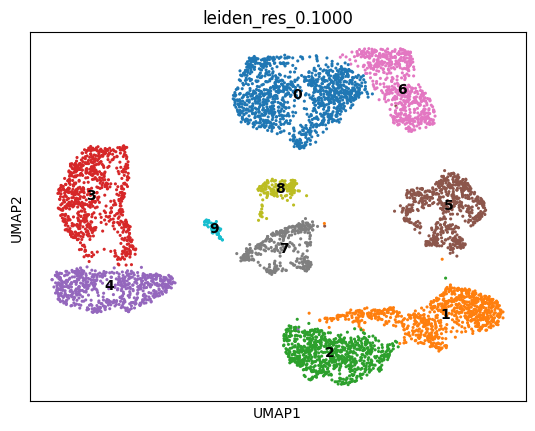

Indice de Rand ajusté (ARI) : 0.6524537909838517
Normalized mutual info (NMI) : 0.813250666361027
Clustering accuracy (CA) : 0.6817272424141381


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 166.10785675048828
ARI 0.36387, NMI: 0.55505, CA : 0.51267, clusters : 3
val_loss : 35.5867075920105
val_ARI 0.34688, val_NMI: 0.51587, val_CA : 0.49261
1). Loss : 152.19533491134644
ARI 0.591, NMI: 0.66519, CA : 0.75375, clusters : 5
val_loss : 34.20642614364624
val_ARI 0.49244, val_NMI: 0.60132, val_CA : 0.70506
2). Loss : 146.75005292892456
ARI 0.77373, NMI: 0.78368, CA : 0.81761, clusters : 5
val_loss : 32.66059470176697
val_ARI 0.75248, val_NMI: 0.75083, val_CA : 0.80856
3). Loss : 140.13970851898193
ARI 0.69133, NMI: 0.75527, CA : 0.75642, clusters : 6
val_loss : 31.251842498779297
val_ARI 0.68209, val_NMI: 0.73411, val_CA : 0.75253
4). Loss : 137.0681347846985
ARI 0.77649, NMI: 0.79218, CA : 0.81744, clusters : 5
val_loss : 30.806261777877808
val_ARI 0.77299, val_NMI: 0.78418, val_CA : 0.81556
5). Loss : 134.97775316238403
ARI 0.76927, NMI: 0.79159, CA : 0.81727, clusters : 5
val_loss : 30.32670259475708
val_ARI 0.76823, val_NMI: 0.77684, val_CA : 0.81401
6). Loss : 1

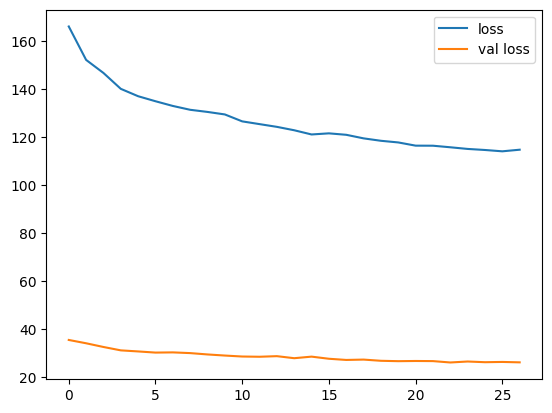

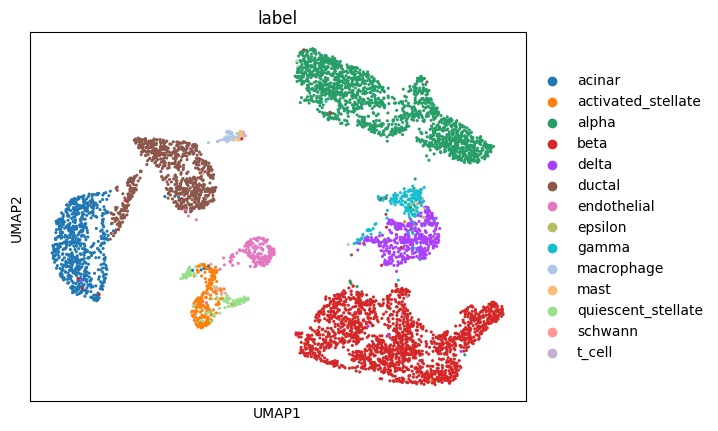

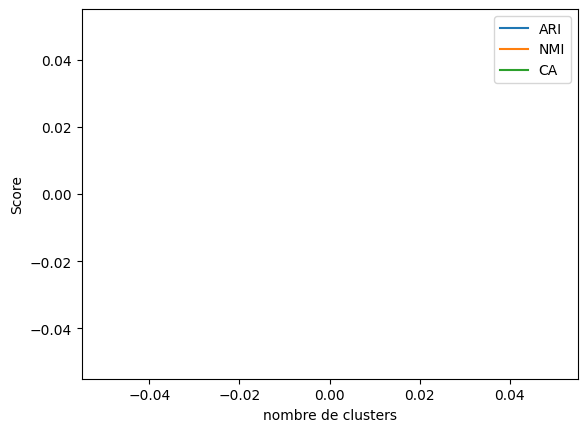

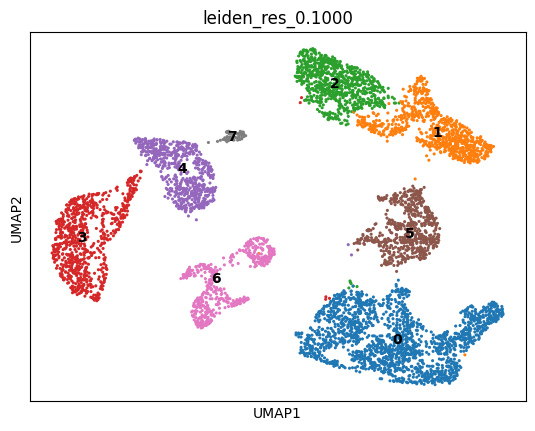

Indice de Rand ajusté (ARI) : 0.7942188313091237
Normalized mutual info (NMI) : 0.8352336029659021
Clustering accuracy (CA) : 0.7515838612870956


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 173.32272338867188
ARI 0.3625, NMI: 0.55445, CA : 0.51434, clusters : 3
val_loss : 36.654812812805176
val_ARI 0.35139, val_NMI: 0.51881, val_CA : 0.50584
1). Loss : 155.22072505950928
ARI 0.55648, NMI: 0.65898, CA : 0.73608, clusters : 5
val_loss : 34.529213428497314
val_ARI 0.4447, val_NMI: 0.59912, val_CA : 0.67782
2). Loss : 147.7990198135376
ARI 0.74904, NMI: 0.76715, CA : 0.8071, clusters : 5
val_loss : 33.05545711517334
val_ARI 0.73373, val_NMI: 0.75275, val_CA : 0.80389
3). Loss : 142.28515148162842
ARI 0.76729, NMI: 0.78776, CA : 0.8141, clusters : 5
val_loss : 31.587698459625244
val_ARI 0.75719, val_NMI: 0.77019, val_CA : 0.81012
4). Loss : 138.5099277496338
ARI 0.77514, NMI: 0.78938, CA : 0.81711, clusters : 5
val_loss : 31.36167812347412
val_ARI 0.76633, val_NMI: 0.76588, val_CA : 0.81401
5). Loss : 136.17381811141968
ARI 0.76791, NMI: 0.78261, CA : 0.81394, clusters : 5
val_loss : 30.567051887512207
val_ARI 0.76089, val_NMI: 0.75886, val_CA : 0.80934
6). Loss : 1

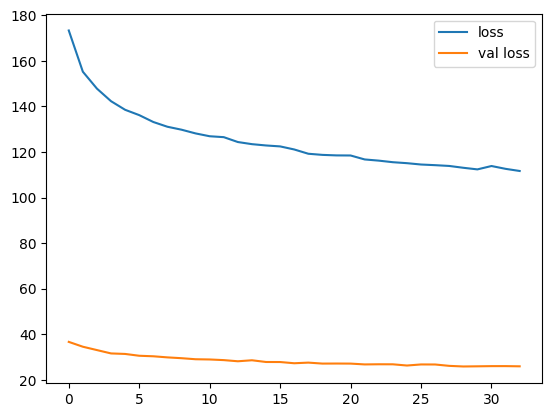

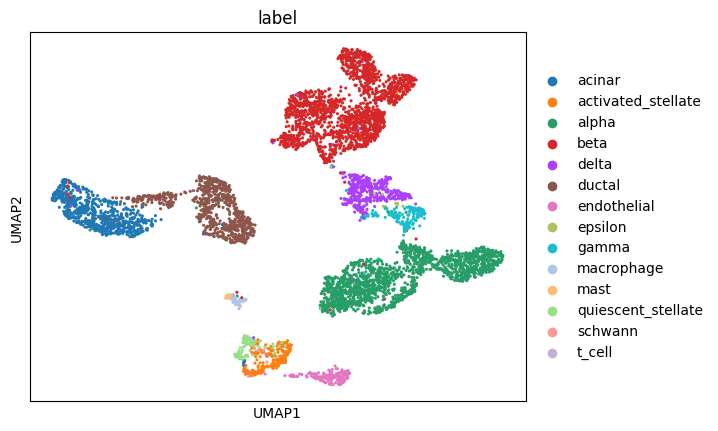

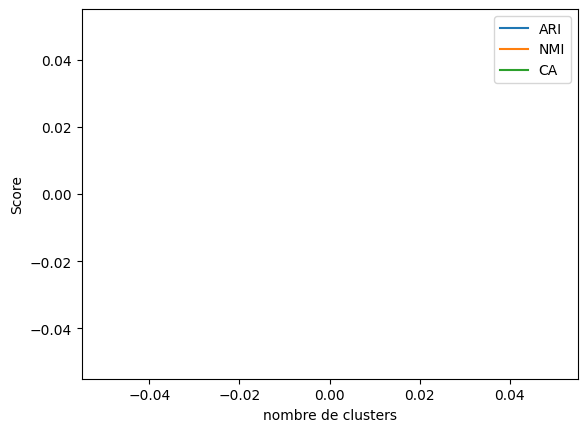

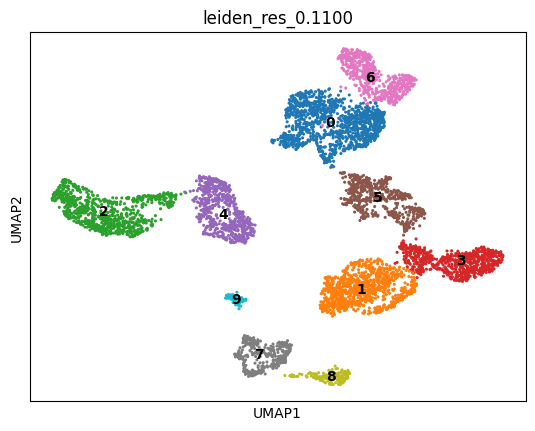

Indice de Rand ajusté (ARI) : 0.6536581872818905
Normalized mutual info (NMI) : 0.8096803341315048
Clustering accuracy (CA) : 0.7010670223407802


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 167.45767402648926
ARI 0.56262, NMI: 0.61598, CA : 0.72541, clusters : 4
val_loss : 35.420034408569336
val_ARI 0.41485, val_NMI: 0.53348, val_CA : 0.65136
1). Loss : 152.45148277282715
ARI 0.74961, NMI: 0.75729, CA : 0.80677, clusters : 5
val_loss : 33.756516456604004
val_ARI 0.73813, val_NMI: 0.73891, val_CA : 0.80389
2). Loss : 144.83369541168213
ARI 0.77076, NMI: 0.78285, CA : 0.81661, clusters : 5
val_loss : 32.43281316757202
val_ARI 0.77747, val_NMI: 0.77754, val_CA : 0.81868
3). Loss : 139.96342706680298
ARI 0.77085, NMI: 0.7851, CA : 0.81511, clusters : 5
val_loss : 31.657458305358887
val_ARI 0.77182, val_NMI: 0.7703, val_CA : 0.81401
4). Loss : 136.9385061264038
ARI 0.77783, NMI: 0.79685, CA : 0.81627, clusters : 5
val_loss : 31.204150199890137
val_ARI 0.76217, val_NMI: 0.76098, val_CA : 0.81089
5). Loss : 134.39737462997437
ARI 0.89435, NMI: 0.8424, CA : 0.87446, clusters : 6
val_loss : 30.512368202209473
val_ARI 0.85355, val_NMI: 0.80175, val_CA : 0.8537
6). Loss :

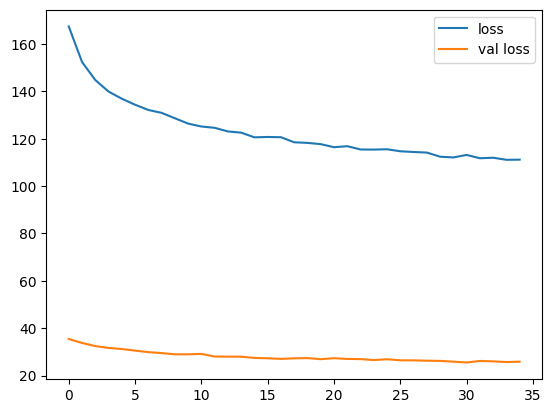

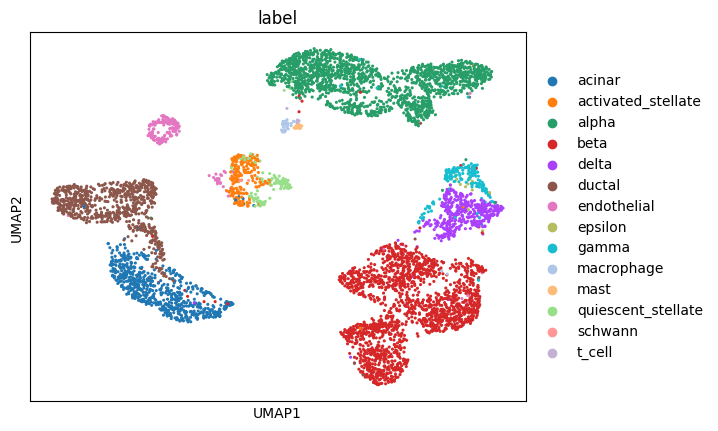

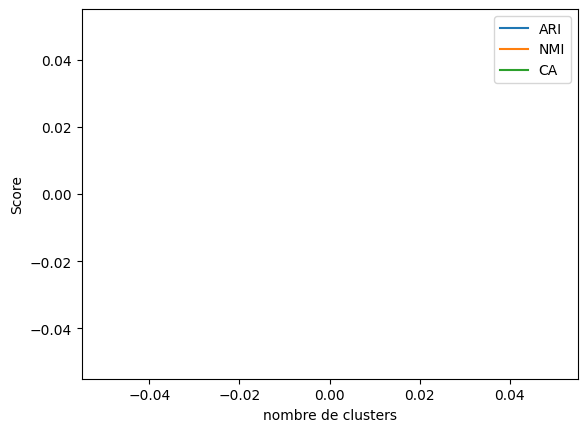

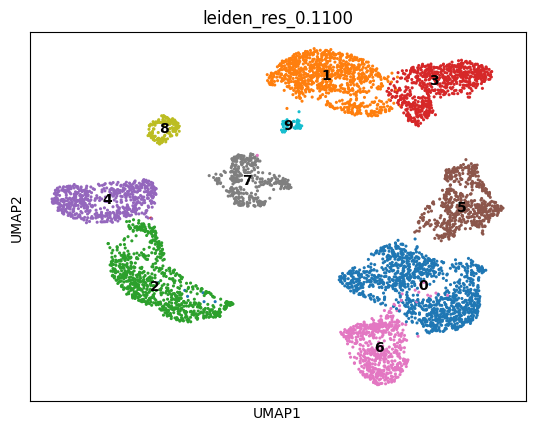

Indice de Rand ajusté (ARI) : 0.6552359257669798
Normalized mutual info (NMI) : 0.8080176684088779
Clustering accuracy (CA) : 0.6980660220073358


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 167.14514923095703
ARI 0.32179, NMI: 0.49454, CA : 0.52117, clusters : 4
val_loss : 35.8207631111145
val_ARI 0.29004, val_NMI: 0.45606, val_CA : 0.50895
1). Loss : 154.36979484558105
ARI 0.3991, NMI: 0.57137, CA : 0.63271, clusters : 4
val_loss : 34.554723262786865
val_ARI 0.39168, val_NMI: 0.54014, val_CA : 0.63268
2). Loss : 149.0411262512207
ARI 0.76279, NMI: 0.76713, CA : 0.81177, clusters : 5
val_loss : 33.09456539154053
val_ARI 0.70441, val_NMI: 0.72246, val_CA : 0.79144
3). Loss : 142.4773645401001
ARI 0.77765, NMI: 0.79092, CA : 0.81561, clusters : 5
val_loss : 31.72514295578003
val_ARI 0.75874, val_NMI: 0.76046, val_CA : 0.81012
4). Loss : 138.14092445373535
ARI 0.72294, NMI: 0.77536, CA : 0.78593, clusters : 6
val_loss : 30.9085636138916
val_ARI 0.70029, val_NMI: 0.72961, val_CA : 0.76342
5). Loss : 135.0507116317749
ARI 0.71335, NMI: 0.75082, CA : 0.74692, clusters : 6
val_loss : 30.625068187713623
val_ARI 0.67591, val_NMI: 0.72827, val_CA : 0.70506
6). Loss : 133

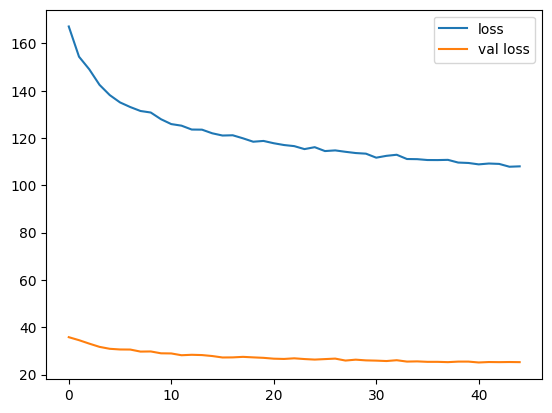

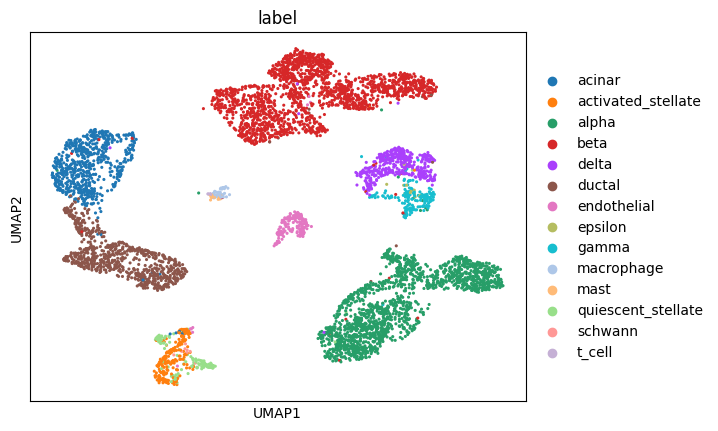

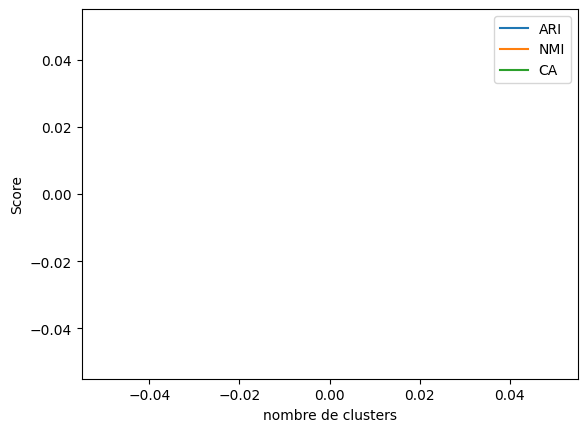

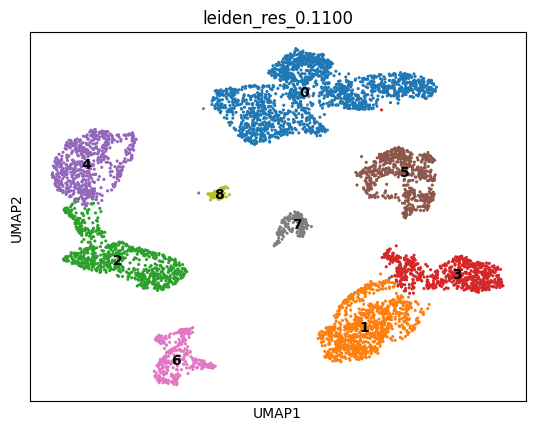

Indice de Rand ajusté (ARI) : 0.8352137146140591
Normalized mutual info (NMI) : 0.8802989387347346
Clustering accuracy (CA) : 0.8166055351783928


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_9 (Lambda)               │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 168.3844575881958
ARI 0.38878, NMI: 0.6044, CA : 0.54168, clusters : 4
val_loss : 35.87724828720093
val_ARI 0.38609, val_NMI: 0.58336, val_CA : 0.53774
1). Loss : 154.90296697616577
ARI 0.44227, NMI: 0.61493, CA : 0.66656, clusters : 5
val_loss : 34.425639629364014
val_ARI 0.34297, val_NMI: 0.54517, val_CA : 0.59144
2). Loss : 149.7483320236206
ARI 0.72748, NMI: 0.74278, CA : 0.80143, clusters : 5
val_loss : 33.42407274246216
val_ARI 0.69369, val_NMI: 0.71104, val_CA : 0.78911
3). Loss : 145.1904902458191
ARI 0.76676, NMI: 0.7717, CA : 0.8136, clusters : 5
val_loss : 32.75887203216553
val_ARI 0.72082, val_NMI: 0.73838, val_CA : 0.8
4). Loss : 140.506028175354
ARI 0.77367, NMI: 0.78868, CA : 0.81644, clusters : 5
val_loss : 31.459644317626953
val_ARI 0.76427, val_NMI: 0.7632, val_CA : 0.81012
5). Loss : 136.78905725479126
ARI 0.88585, NMI: 0.83415, CA : 0.87196, clusters : 6
val_loss : 30.84897494316101
val_ARI 0.77722, val_NMI: 0.78687, val_CA : 0.82568
6). Loss : 134.230193

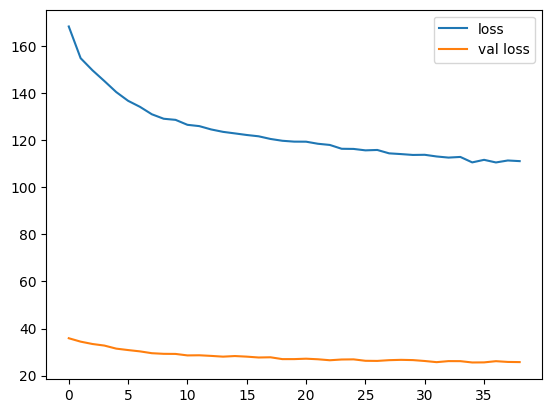

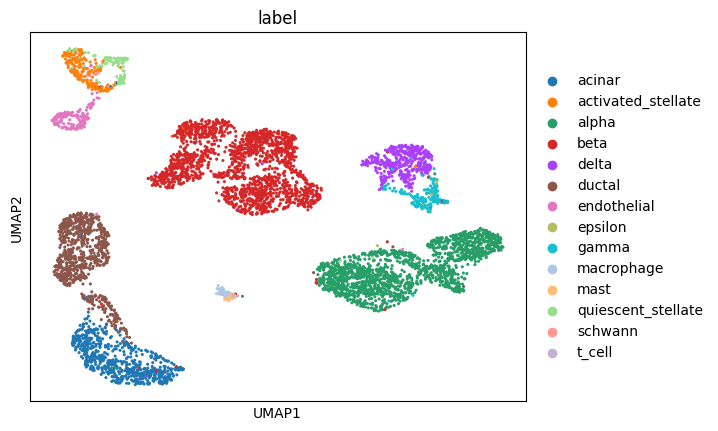

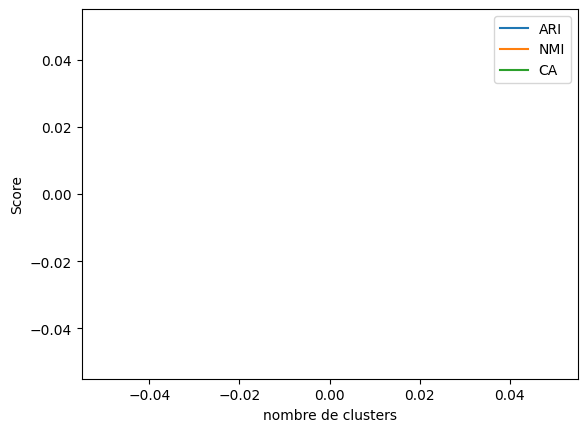

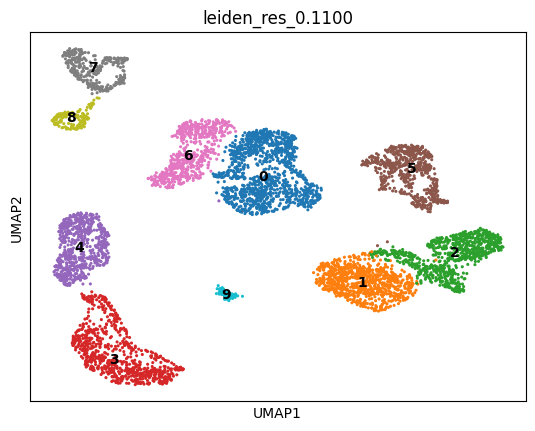

Indice de Rand ajusté (ARI) : 0.6547162602318298
Normalized mutual info (NMI) : 0.8151054356970133
Clustering accuracy (CA) : 0.6822274091363788


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_10 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 165.95041513442993
ARI 0.36447, NMI: 0.54292, CA : 0.51117, clusters : 3
val_loss : 35.23565149307251
val_ARI 0.36543, val_NMI: 0.54966, val_CA : 0.51284
1). Loss : 152.3403353691101
ARI 0.7477, NMI: 0.75453, CA : 0.80844, clusters : 5
val_loss : 33.90004634857178
val_ARI 0.70202, val_NMI: 0.71585, val_CA : 0.793
2). Loss : 145.6896266937256
ARI 0.7653, NMI: 0.78098, CA : 0.81527, clusters : 5
val_loss : 32.476762771606445
val_ARI 0.78153, val_NMI: 0.79483, val_CA : 0.82101
3). Loss : 139.8477339744568
ARI 0.76665, NMI: 0.78481, CA : 0.81677, clusters : 5
val_loss : 31.38170337677002
val_ARI 0.76988, val_NMI: 0.78609, val_CA : 0.81556
4). Loss : 136.9320855140686
ARI 0.77275, NMI: 0.79488, CA : 0.81827, clusters : 5
val_loss : 30.72834086418152
val_ARI 0.77844, val_NMI: 0.78094, val_CA : 0.8179
5). Loss : 133.7069001197815
ARI 0.8965, NMI: 0.84124, CA : 0.87513, clusters : 6
val_loss : 30.138518571853638
val_ARI 0.86874, val_NMI: 0.82752, val_CA : 0.85992
6). Loss : 130.9071

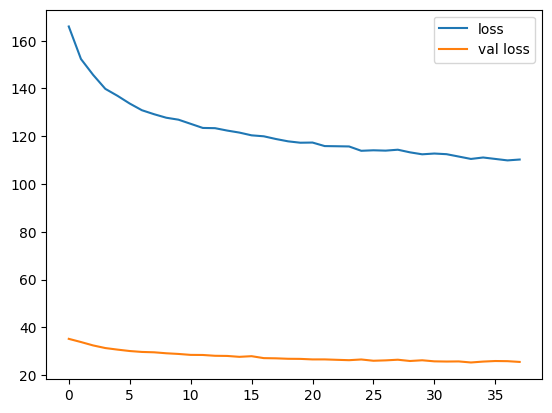

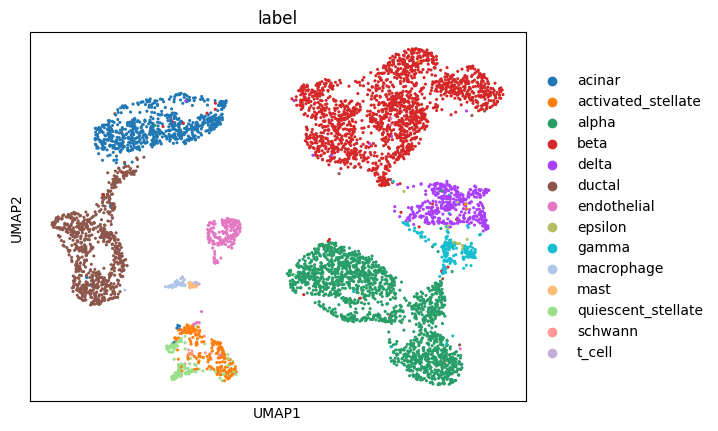

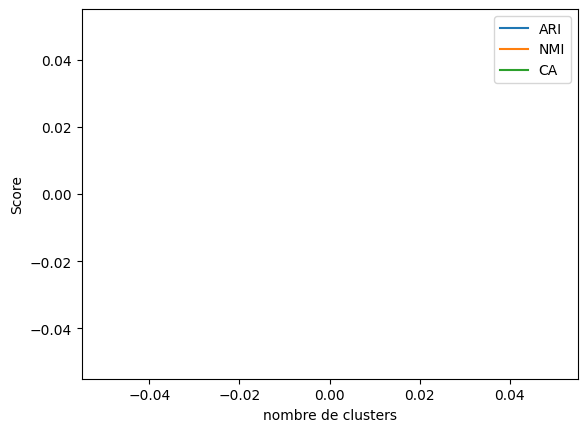

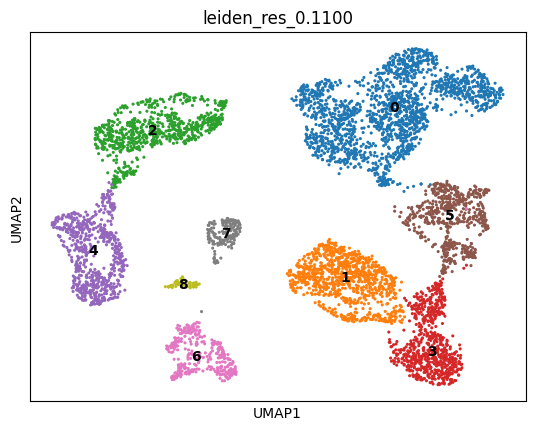

Indice de Rand ajusté (ARI) : 0.8159540199231523
Normalized mutual info (NMI) : 0.8563246686200253
Clustering accuracy (CA) : 0.8059353117705902


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_11 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 168.7312045097351
ARI 0.36453, NMI: 0.55655, CA : 0.51334, clusters : 3
val_loss : 35.7352876663208
val_ARI 0.36258, val_NMI: 0.53223, val_CA : 0.51284
1). Loss : 153.2033929824829
ARI 0.74185, NMI: 0.74588, CA : 0.80493, clusters : 5
val_loss : 33.99100160598755
val_ARI 0.69744, val_NMI: 0.70982, val_CA : 0.78911
2). Loss : 145.46961545944214
ARI 0.7713, NMI: 0.78582, CA : 0.81527, clusters : 5
val_loss : 32.37028431892395
val_ARI 0.75775, val_NMI: 0.76044, val_CA : 0.80778
3). Loss : 140.16822910308838
ARI 0.84531, NMI: 0.80863, CA : 0.85795, clusters : 6
val_loss : 31.5953688621521
val_ARI 0.8329, val_NMI: 0.8066, val_CA : 0.85447
4). Loss : 136.50754261016846
ARI 0.88747, NMI: 0.83454, CA : 0.87312, clusters : 6
val_loss : 30.972153902053833
val_ARI 0.85457, val_NMI: 0.80973, val_CA : 0.8537
5). Loss : 134.2113242149353
ARI 0.78233, NMI: 0.79821, CA : 0.76909, clusters : 7
val_loss : 30.17159414291382
val_ARI 0.74621, val_NMI: 0.77591, val_CA : 0.75331
6). Loss : 132.349

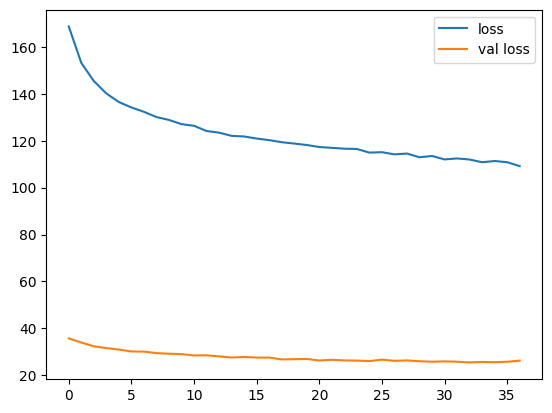

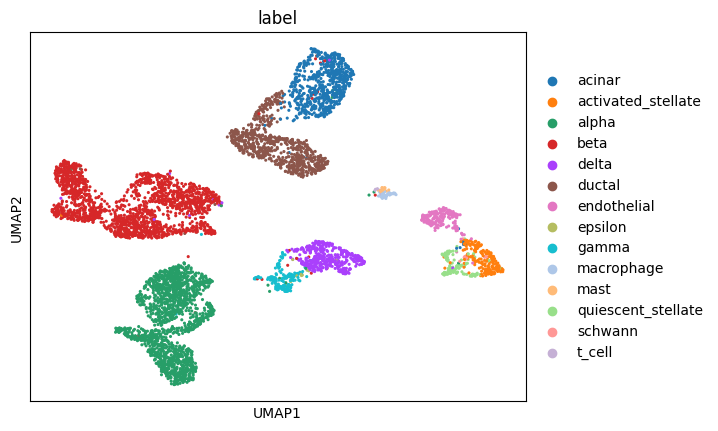

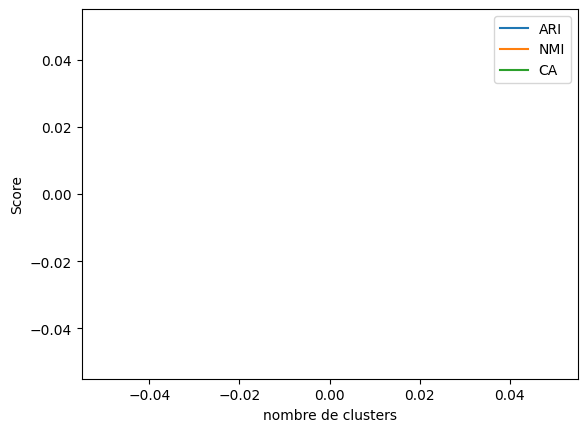

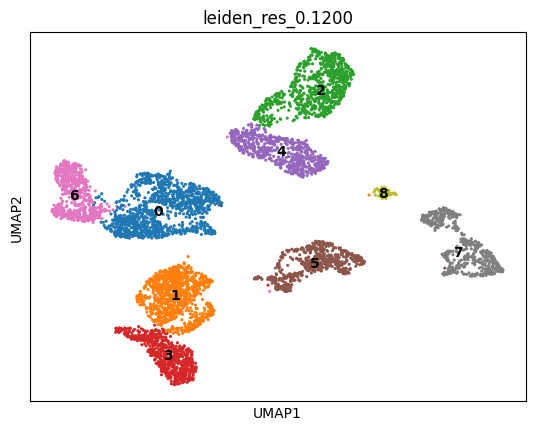

Indice de Rand ajusté (ARI) : 0.6508190375542248
Normalized mutual info (NMI) : 0.8031025450709309
Clustering accuracy (CA) : 0.675891963987996


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_12 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 166.9100341796875
ARI 0.48264, NMI: 0.62416, CA : 0.7064, clusters : 5
val_loss : 35.709564208984375
val_ARI 0.45599, val_NMI: 0.57467, val_CA : 0.68716
1). Loss : 153.5999321937561
ARI 0.73718, NMI: 0.75423, CA : 0.80544, clusters : 5
val_loss : 34.123741149902344
val_ARI 0.71031, val_NMI: 0.72203, val_CA : 0.79844
2). Loss : 146.22067022323608
ARI 0.77672, NMI: 0.79362, CA : 0.81861, clusters : 5
val_loss : 32.6884880065918
val_ARI 0.77389, val_NMI: 0.78807, val_CA : 0.81712
3). Loss : 140.59068393707275
ARI 0.78185, NMI: 0.79822, CA : 0.82127, clusters : 5
val_loss : 31.78761100769043
val_ARI 0.76902, val_NMI: 0.76735, val_CA : 0.81245
4). Loss : 137.0951156616211
ARI 0.86356, NMI: 0.8286, CA : 0.87046, clusters : 6
val_loss : 30.781458377838135
val_ARI 0.80846, val_NMI: 0.7805, val_CA : 0.84358
5). Loss : 135.74330043792725
ARI 0.90765, NMI: 0.85862, CA : 0.88429, clusters : 7
val_loss : 30.391449213027954
val_ARI 0.866, val_NMI: 0.82266, val_CA : 0.86148
6). Loss : 133.

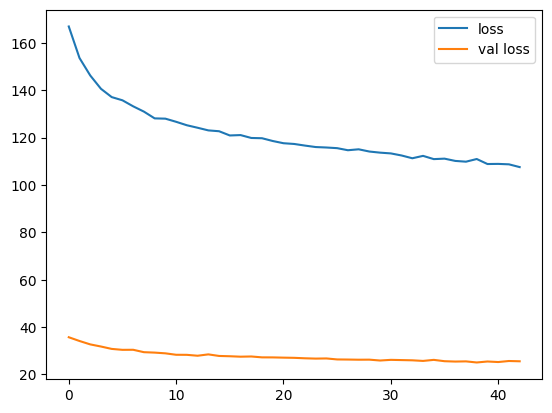

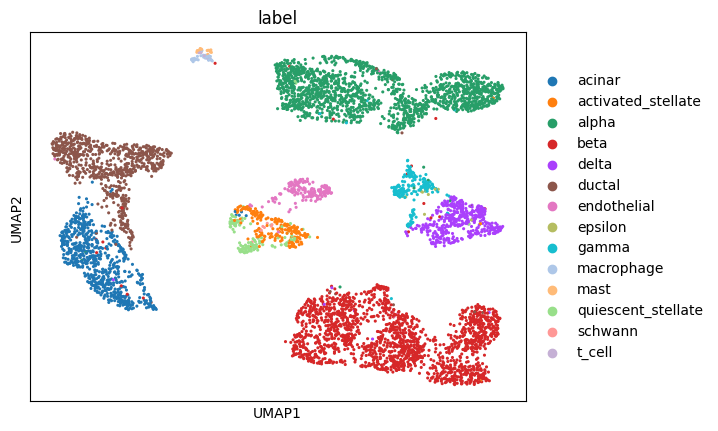

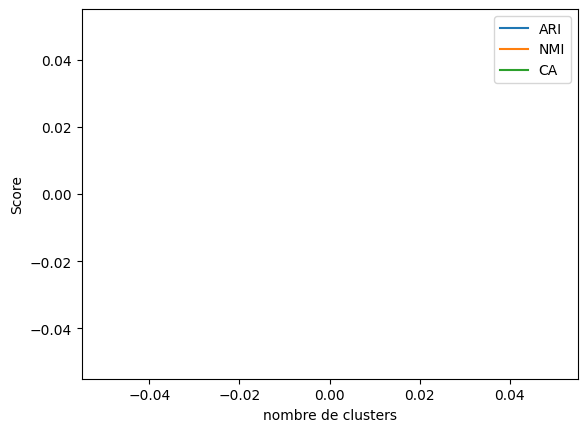

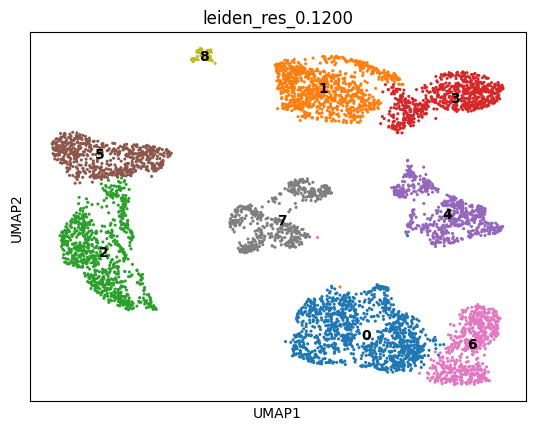

Indice de Rand ajusté (ARI) : 0.6458670275159696
Normalized mutual info (NMI) : 0.7965246143579668
Clustering accuracy (CA) : 0.6715571857285761


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_13 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 167.21377420425415
ARI 0.36446, NMI: 0.55331, CA : 0.51501, clusters : 3
val_loss : 35.714871883392334
val_ARI 0.34897, val_NMI: 0.51592, val_CA : 0.4786
1). Loss : 153.31290674209595
ARI 0.53544, NMI: 0.63482, CA : 0.72407, clusters : 5
val_loss : 34.30544662475586
val_ARI 0.45852, val_NMI: 0.58708, val_CA : 0.68482
2). Loss : 147.79885959625244
ARI 0.75722, NMI: 0.77262, CA : 0.81144, clusters : 5
val_loss : 32.64977788925171
val_ARI 0.75657, val_NMI: 0.76245, val_CA : 0.81089
3). Loss : 141.85647296905518
ARI 0.7602, NMI: 0.78358, CA : 0.81177, clusters : 5
val_loss : 31.56503462791443
val_ARI 0.76539, val_NMI: 0.76669, val_CA : 0.81245
4). Loss : 137.768967628479
ARI 0.76771, NMI: 0.78181, CA : 0.81511, clusters : 5
val_loss : 31.099828004837036
val_ARI 0.77232, val_NMI: 0.77093, val_CA : 0.81479
5). Loss : 134.91008615493774
ARI 0.90015, NMI: 0.84711, CA : 0.87763, clusters : 6
val_loss : 30.65875816345215
val_ARI 0.8778, val_NMI: 0.83174, val_CA : 0.87082
6). Loss : 13

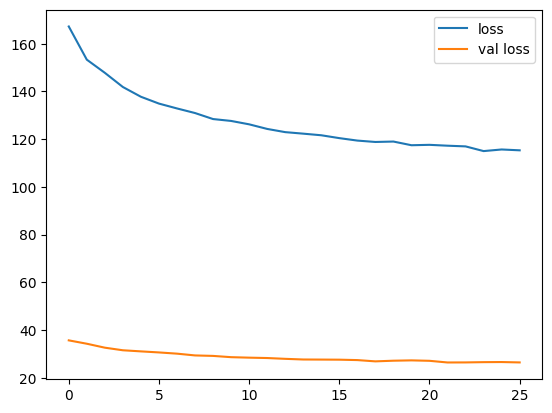

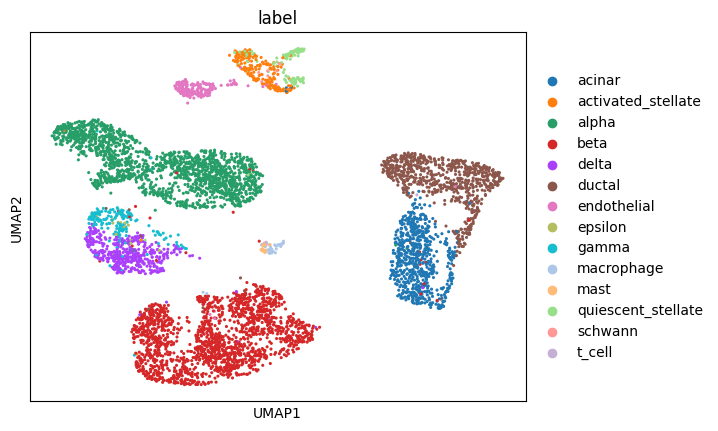

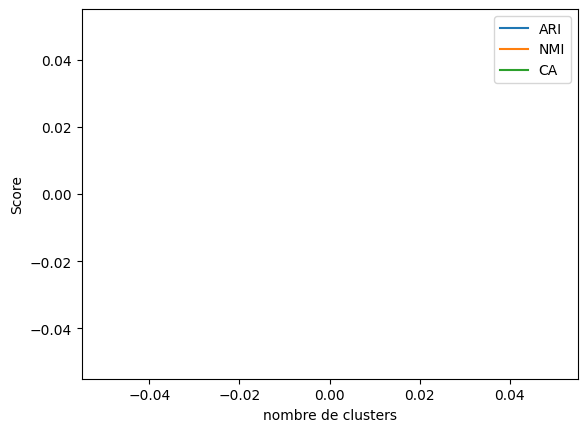

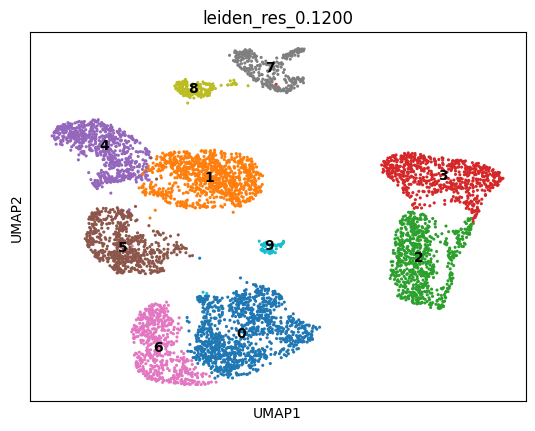

Indice de Rand ajusté (ARI) : 0.6649715990111293
Normalized mutual info (NMI) : 0.8153841760059475
Clustering accuracy (CA) : 0.7072357452484161


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_14 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 168.12592029571533
ARI 0.3092, NMI: 0.48785, CA : 0.56102, clusters : 4
val_loss : 36.18449354171753
val_ARI 0.32539, val_NMI: 0.48671, val_CA : 0.57198
1). Loss : 153.66565608978271
ARI 0.68712, NMI: 0.71523, CA : 0.78876, clusters : 5
val_loss : 34.256011962890625
val_ARI 0.60296, val_NMI: 0.65964, val_CA : 0.75486
2). Loss : 145.97549962997437
ARI 0.77581, NMI: 0.79178, CA : 0.81694, clusters : 5
val_loss : 32.50049829483032
val_ARI 0.76391, val_NMI: 0.76348, val_CA : 0.81245
3). Loss : 139.9272346496582
ARI 0.77179, NMI: 0.78364, CA : 0.81544, clusters : 5
val_loss : 31.611005544662476
val_ARI 0.77697, val_NMI: 0.79072, val_CA : 0.81712
4). Loss : 136.79212284088135
ARI 0.57871, NMI: 0.72806, CA : 0.66472, clusters : 7
val_loss : 30.951797246932983
val_ARI 0.5633, val_NMI: 0.71281, val_CA : 0.64125
5). Loss : 134.34894132614136
ARI 0.77757, NMI: 0.79683, CA : 0.76192, clusters : 7
val_loss : 30.205034255981445
val_ARI 0.75719, val_NMI: 0.78611, val_CA : 0.75953
6). Loss 

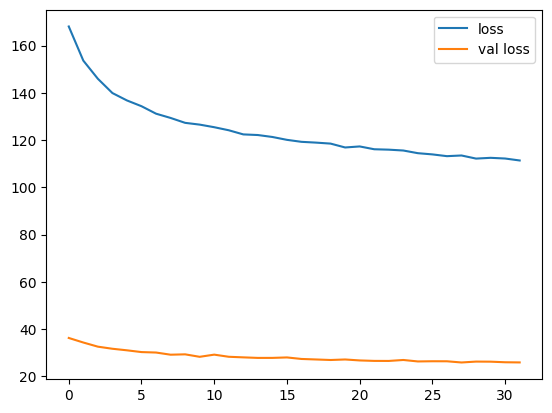

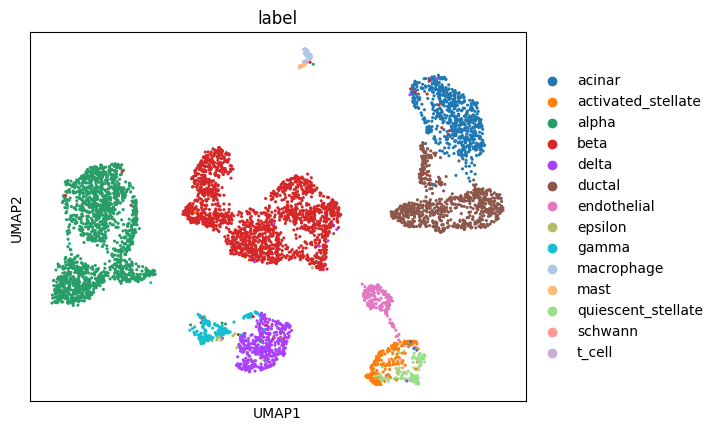

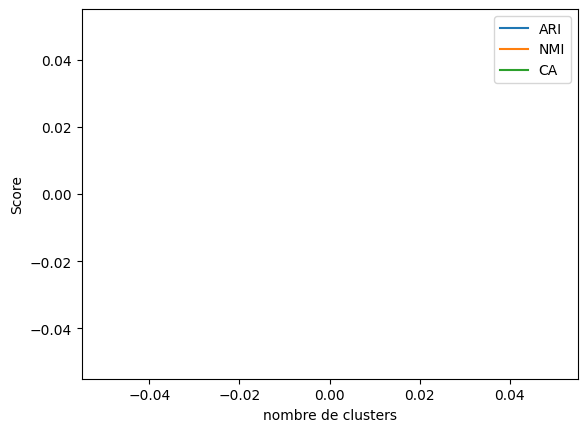

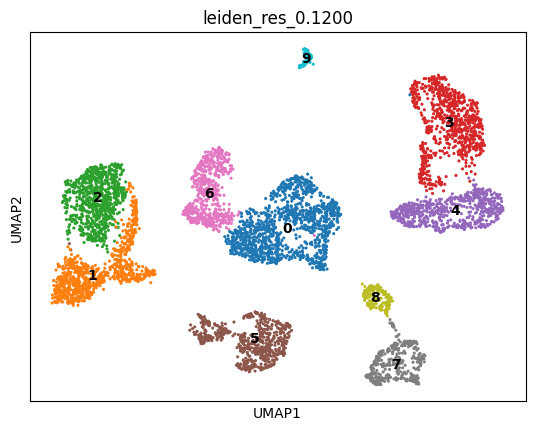

Indice de Rand ajusté (ARI) : 0.6509373167836322
Normalized mutual info (NMI) : 0.8110576879987361
Clustering accuracy (CA) : 0.6785595198399467


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_29 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_15 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 167.30659437179565
ARI 0.30091, NMI: 0.48444, CA : 0.53751, clusters : 4
val_loss : 35.82916450500488
val_ARI 0.32907, val_NMI: 0.47713, val_CA : 0.53541
1). Loss : 154.44495010375977
ARI 0.35858, NMI: 0.55173, CA : 0.58003, clusters : 5
val_loss : 34.81543684005737
val_ARI 0.35325, val_NMI: 0.53397, val_CA : 0.58599
2). Loss : 149.51538133621216
ARI 0.64453, NMI: 0.71929, CA : 0.71357, clusters : 6
val_loss : 33.55774641036987
val_ARI 0.6207, val_NMI: 0.67995, val_CA : 0.7284
3). Loss : 141.64333391189575
ARI 0.69905, NMI: 0.75302, CA : 0.76992, clusters : 6
val_loss : 31.565001010894775
val_ARI 0.68699, val_NMI: 0.7459, val_CA : 0.75798
4). Loss : 137.5837607383728
ARI 0.58734, NMI: 0.72518, CA : 0.67206, clusters : 7
val_loss : 30.9765784740448
val_ARI 0.56151, val_NMI: 0.70917, val_CA : 0.6428
5). Loss : 134.28834629058838
ARI 0.78513, NMI: 0.80977, CA : 0.76709, clusters : 7
val_loss : 30.363508224487305
val_ARI 0.7566, val_NMI: 0.76225, val_CA : 0.77977
6). Loss : 132.

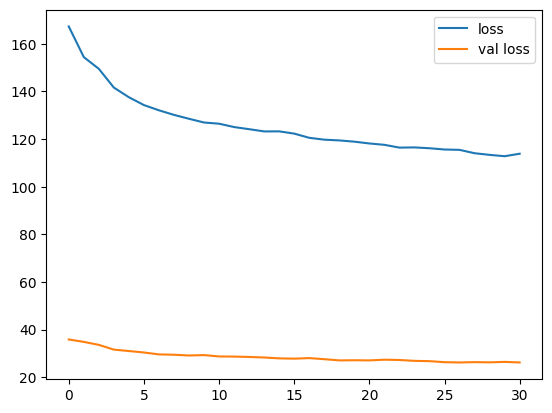

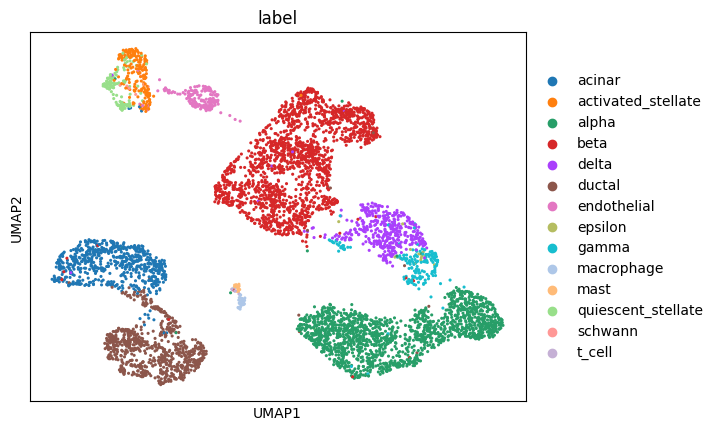

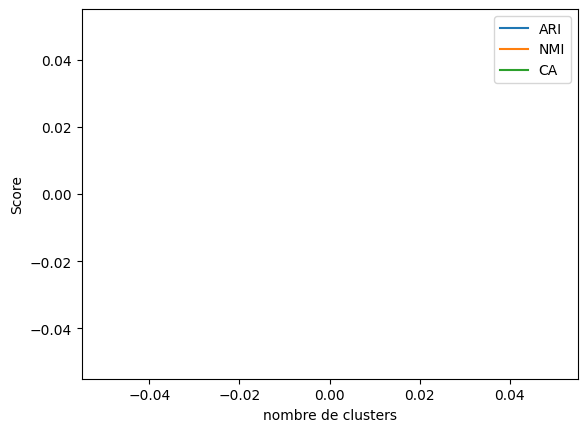

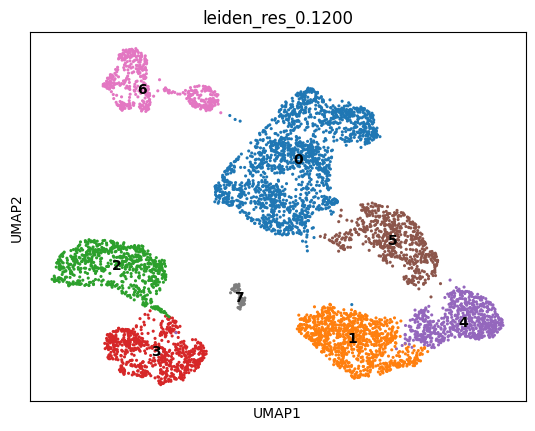

Indice de Rand ajusté (ARI) : 0.8106326038860776
Normalized mutual info (NMI) : 0.8461635325200292
Clustering accuracy (CA) : 0.7819273091030343


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_30 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_31 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_16 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 169.51078701019287
ARI 0.33488, NMI: 0.49214, CA : 0.52467, clusters : 4
val_loss : 35.87865447998047
val_ARI 0.32832, val_NMI: 0.48604, val_CA : 0.53074
1). Loss : 153.89431524276733
ARI 0.68584, NMI: 0.70722, CA : 0.78826, clusters : 5
val_loss : 34.36283731460571
val_ARI 0.58679, val_NMI: 0.65874, val_CA : 0.75097
2). Loss : 147.41389656066895
ARI 0.77071, NMI: 0.77935, CA : 0.81727, clusters : 5
val_loss : 32.65298366546631
val_ARI 0.7633, val_NMI: 0.76322, val_CA : 0.81167
3). Loss : 140.65564107894897
ARI 0.88912, NMI: 0.83869, CA : 0.87429, clusters : 6
val_loss : 31.56543779373169
val_ARI 0.81236, val_NMI: 0.77384, val_CA : 0.83113
4). Loss : 136.8614625930786
ARI 0.88426, NMI: 0.83101, CA : 0.87196, clusters : 6
val_loss : 31.107258796691895
val_ARI 0.87572, val_NMI: 0.82231, val_CA : 0.87082
5). Loss : 134.10960054397583
ARI 0.58831, NMI: 0.72153, CA : 0.67623, clusters : 7
val_loss : 30.554794549942017
val_ARI 0.55719, val_NMI: 0.69173, val_CA : 0.63268
6). Loss :

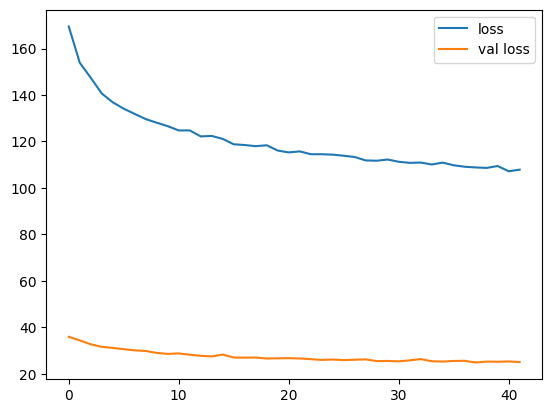

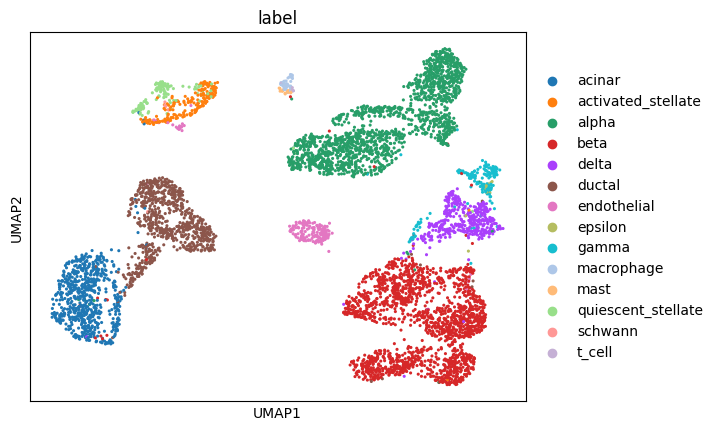

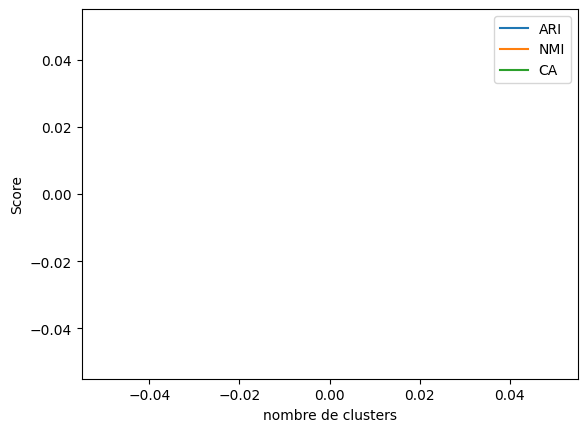

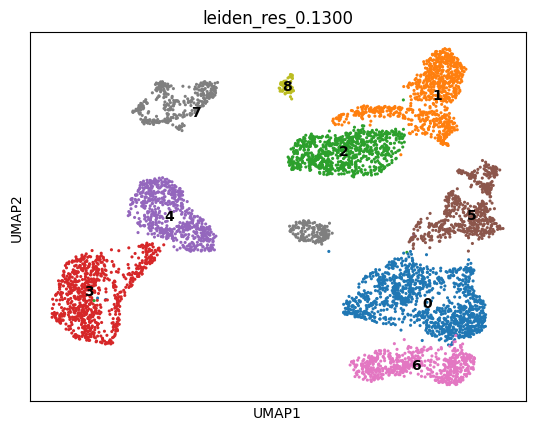

Indice de Rand ajusté (ARI) : 0.6413501241284674
Normalized mutual info (NMI) : 0.7947582803634696
Clustering accuracy (CA) : 0.6530510170056686


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_32 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_33 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_17 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 166.96579217910767
ARI 0.35347, NMI: 0.51795, CA : 0.51234, clusters : 4
val_loss : 35.38037347793579
val_ARI 0.34782, val_NMI: 0.50975, val_CA : 0.51206
1). Loss : 153.56181955337524
ARI 0.6109, NMI: 0.68492, CA : 0.75942, clusters : 5
val_loss : 34.360777378082275
val_ARI 0.56235, val_NMI: 0.63548, val_CA : 0.73852
2). Loss : 146.68791389465332
ARI 0.75718, NMI: 0.77492, CA : 0.81027, clusters : 6
val_loss : 32.81287956237793
val_ARI 0.72144, val_NMI: 0.74342, val_CA : 0.79066
3). Loss : 140.54181385040283
ARI 0.707, NMI: 0.75962, CA : 0.77059, clusters : 6
val_loss : 31.55995535850525
val_ARI 0.75879, val_NMI: 0.76481, val_CA : 0.80856
4). Loss : 137.47999906539917
ARI 0.87763, NMI: 0.83634, CA : 0.87729, clusters : 6
val_loss : 30.954012870788574
val_ARI 0.86205, val_NMI: 0.81727, val_CA : 0.86304
5). Loss : 134.9463505744934
ARI 0.68719, NMI: 0.75796, CA : 0.74375, clusters : 6
val_loss : 30.23360300064087
val_ARI 0.66782, val_NMI: 0.73755, val_CA : 0.71829
6). Loss : 1

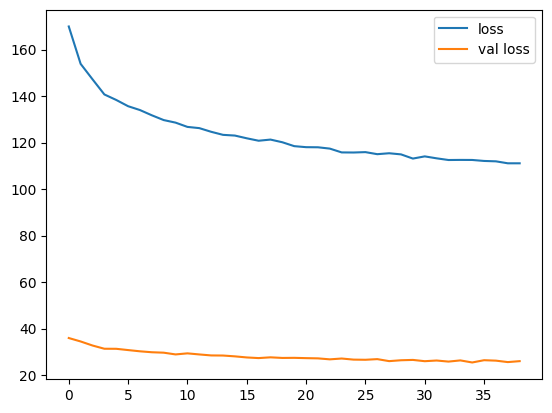

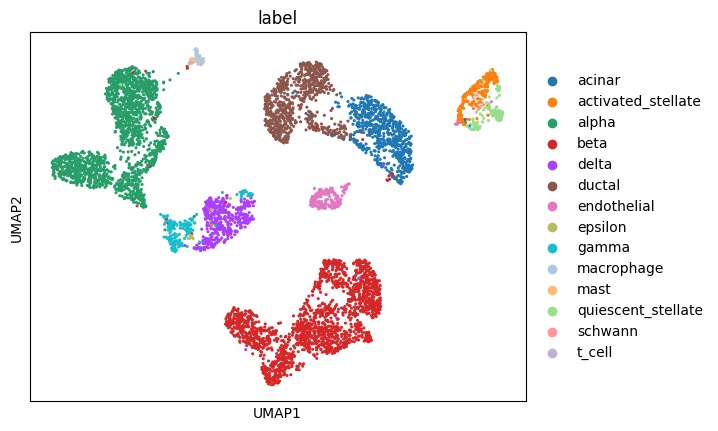

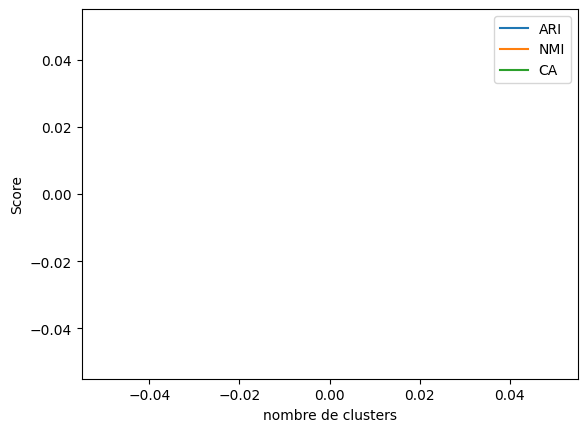

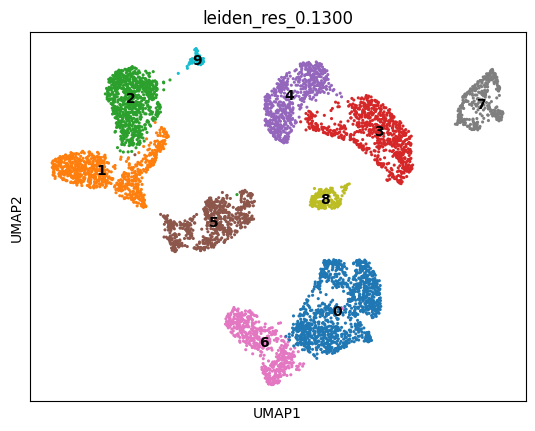

Indice de Rand ajusté (ARI) : 0.6518787274923395
Normalized mutual info (NMI) : 0.8107154695870066
Clustering accuracy (CA) : 0.6817272424141381


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_36 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_37 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_19 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 172.81566286087036
ARI 0.36315, NMI: 0.53861, CA : 0.513, clusters : 3
val_loss : 36.615159034729004
val_ARI 0.35943, val_NMI: 0.52681, val_CA : 0.51206
1). Loss : 155.5742702484131
ARI 0.66883, NMI: 0.6721, CA : 0.76676, clusters : 4
val_loss : 34.603596210479736
val_ARI 0.58575, val_NMI: 0.62666, val_CA : 0.73463
2). Loss : 148.1343231201172
ARI 0.75894, NMI: 0.78457, CA : 0.8126, clusters : 5
val_loss : 32.63558053970337
val_ARI 0.76338, val_NMI: 0.76625, val_CA : 0.81012
3). Loss : 140.6952610015869
ARI 0.76444, NMI: 0.76929, CA : 0.81394, clusters : 5
val_loss : 31.292612552642822
val_ARI 0.7638, val_NMI: 0.75985, val_CA : 0.81556
4). Loss : 137.12798833847046
ARI 0.8899, NMI: 0.83943, CA : 0.87629, clusters : 6
val_loss : 30.666977405548096
val_ARI 0.84929, val_NMI: 0.80536, val_CA : 0.85525
5). Loss : 135.33912801742554
ARI 0.88553, NMI: 0.83743, CA : 0.87329, clusters : 6
val_loss : 30.41658926010132
val_ARI 0.86554, val_NMI: 0.81976, val_CA : 0.86381
6). Loss : 132.

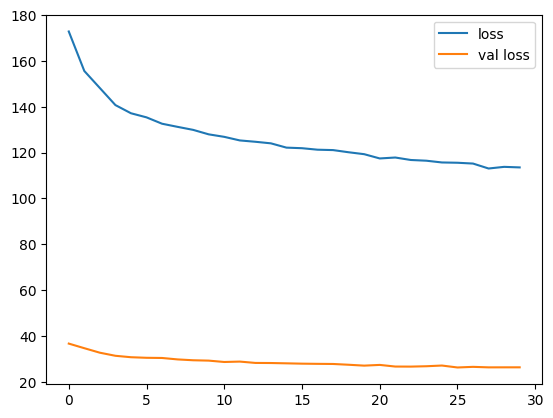

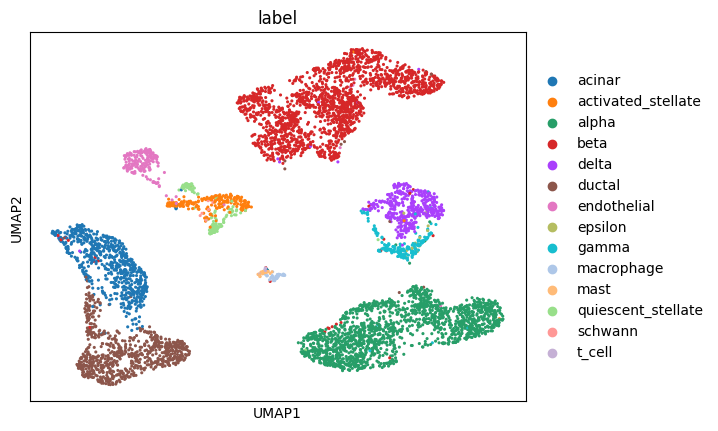

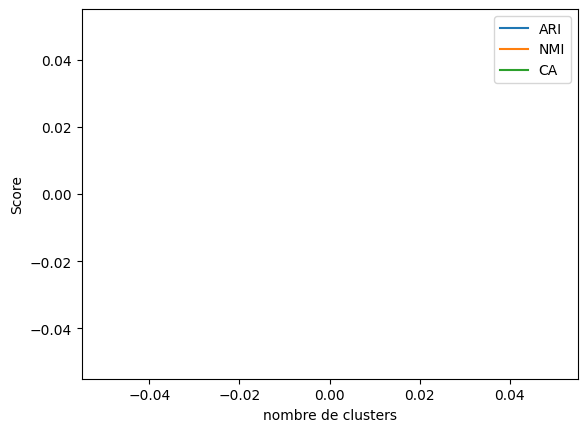

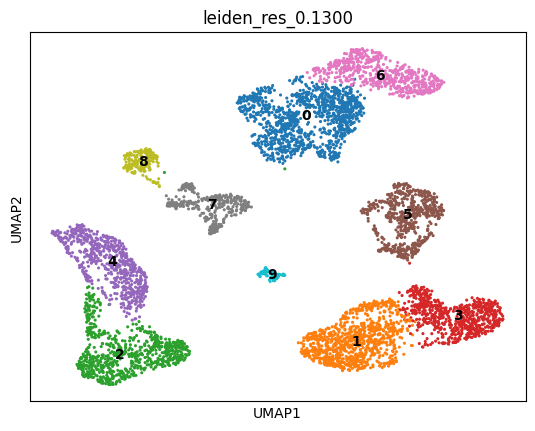

Indice de Rand ajusté (ARI) : 0.6802853711853096
Normalized mutual info (NMI) : 0.8312630346543171
Clustering accuracy (CA) : 0.7155718572857619


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_38 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_39 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_20 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 169.20724439620972
ARI 0.33613, NMI: 0.4986, CA : 0.509, clusters : 4
val_loss : 35.93409824371338
val_ARI 0.29992, val_NMI: 0.46938, val_CA : 0.51284
1). Loss : 154.6390986442566
ARI 0.35948, NMI: 0.54942, CA : 0.54135, clusters : 5
val_loss : 34.69844150543213
val_ARI 0.3577, val_NMI: 0.543, val_CA : 0.53774
2). Loss : 149.75775289535522
ARI 0.65376, NMI: 0.7249, CA : 0.73358, clusters : 6
val_loss : 33.61193633079529
val_ARI 0.62336, val_NMI: 0.69056, val_CA : 0.70428
3). Loss : 142.4300241470337
ARI 0.68068, NMI: 0.74885, CA : 0.74241, clusters : 6
val_loss : 31.97061824798584
val_ARI 0.64477, val_NMI: 0.71386, val_CA : 0.70428
4). Loss : 139.16631889343262
ARI 0.59116, NMI: 0.72543, CA : 0.66739, clusters : 7
val_loss : 31.348583221435547
val_ARI 0.59894, val_NMI: 0.71138, val_CA : 0.66693
5). Loss : 136.18780708312988
ARI 0.73457, NMI: 0.77585, CA : 0.7926, clusters : 6
val_loss : 30.923630952835083
val_ARI 0.65885, val_NMI: 0.73591, val_CA : 0.71984
6). Loss : 133.973

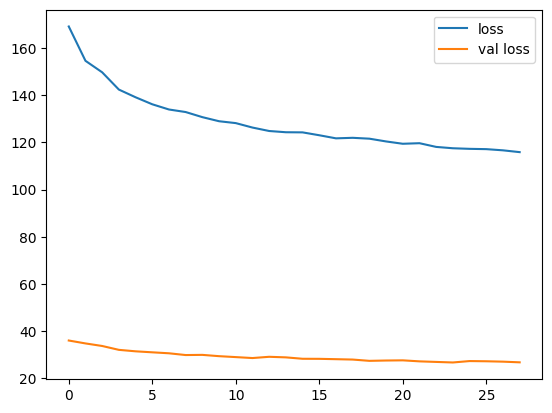

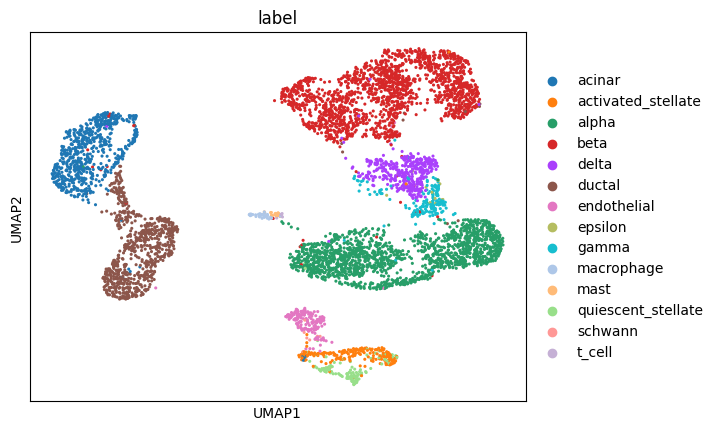

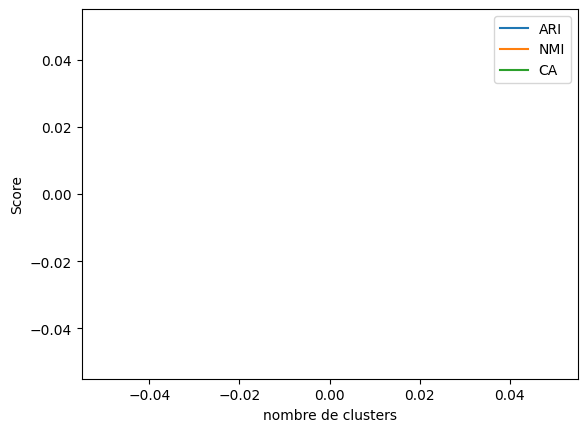

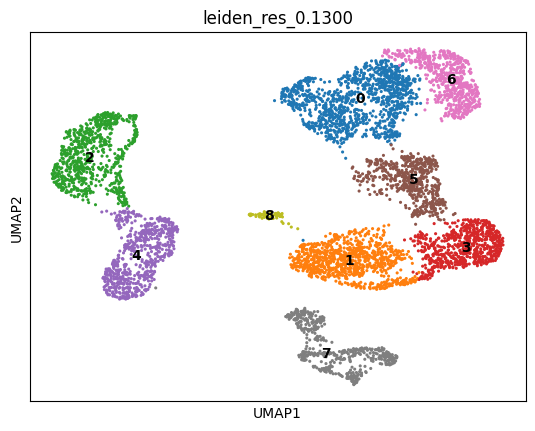

Indice de Rand ajusté (ARI) : 0.651897135536462
Normalized mutual info (NMI) : 0.8003709481492888
Clustering accuracy (CA) : 0.6723907969323107


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_40 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_41 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_21 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 169.0228509902954
ARI 0.35206, NMI: 0.51437, CA : 0.52001, clusters : 4
val_loss : 35.79247999191284
val_ARI 0.33584, val_NMI: 0.49171, val_CA : 0.53152
1). Loss : 153.91314220428467
ARI 0.69561, NMI: 0.71869, CA : 0.79126, clusters : 5
val_loss : 34.312851905822754
val_ARI 0.57602, val_NMI: 0.64121, val_CA : 0.74241
2). Loss : 147.79242992401123
ARI 0.71474, NMI: 0.76224, CA : 0.78093, clusters : 6
val_loss : 32.776336431503296
val_ARI 0.67003, val_NMI: 0.72689, val_CA : 0.73385
3). Loss : 141.11847352981567
ARI 0.86249, NMI: 0.82455, CA : 0.86712, clusters : 6
val_loss : 31.81964659690857
val_ARI 0.81581, val_NMI: 0.77881, val_CA : 0.84125
4). Loss : 137.09459733963013
ARI 0.7197, NMI: 0.77322, CA : 0.78409, clusters : 6
val_loss : 31.024516344070435
val_ARI 0.70589, val_NMI: 0.74412, val_CA : 0.76887
5). Loss : 135.7256784439087
ARI 0.62228, NMI: 0.75222, CA : 0.64822, clusters : 8
val_loss : 30.76231598854065
val_ARI 0.59704, val_NMI: 0.72577, val_CA : 0.62802
6). Loss :

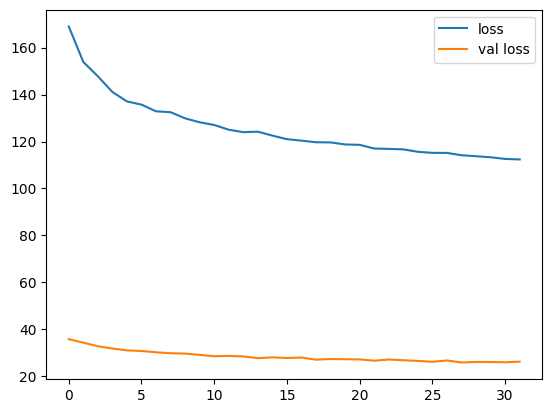

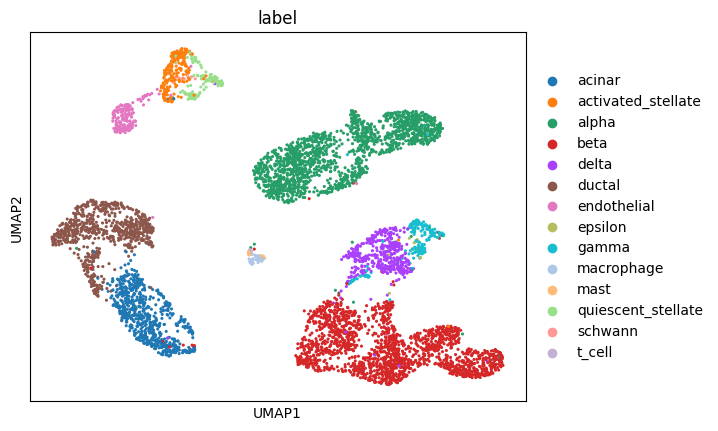

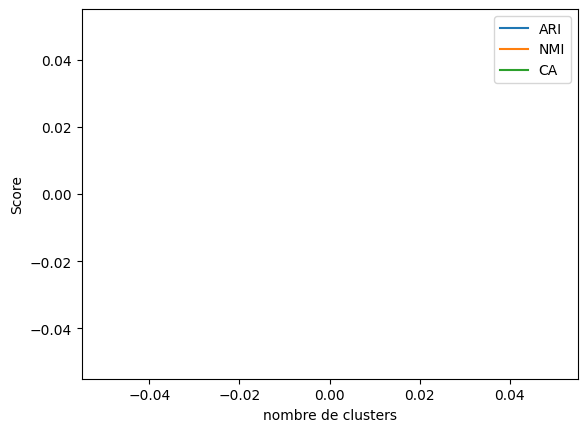

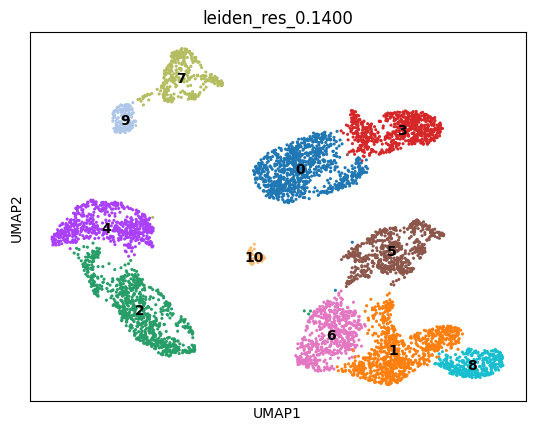

Indice de Rand ajusté (ARI) : 0.5868113214992017
Normalized mutual info (NMI) : 0.7841438422643764
Clustering accuracy (CA) : 0.6465488496165388


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_42 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_43 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_22 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 168.8254041671753
ARI 0.31551, NMI: 0.49764, CA : 0.56819, clusters : 4
val_loss : 35.864291191101074
val_ARI 0.29199, val_NMI: 0.48017, val_CA : 0.52451
1). Loss : 153.73623657226562
ARI 0.70373, NMI: 0.70889, CA : 0.77709, clusters : 4
val_loss : 34.374245166778564
val_ARI 0.67417, val_NMI: 0.68781, val_CA : 0.76887
2). Loss : 146.76371240615845
ARI 0.77198, NMI: 0.76777, CA : 0.82461, clusters : 6
val_loss : 32.83744406700134
val_ARI 0.77875, val_NMI: 0.7563, val_CA : 0.82412
3). Loss : 141.12884712219238
ARI 0.77563, NMI: 0.7919, CA : 0.81694, clusters : 5
val_loss : 31.734198570251465
val_ARI 0.76541, val_NMI: 0.7792, val_CA : 0.81245
4). Loss : 137.23714542388916
ARI 0.77089, NMI: 0.79425, CA : 0.76025, clusters : 7
val_loss : 31.065207958221436
val_ARI 0.72463, val_NMI: 0.75397, val_CA : 0.72918
5). Loss : 134.49338817596436
ARI 0.63982, NMI: 0.7621, CA : 0.65655, clusters : 8
val_loss : 30.415692806243896
val_ARI 0.60881, val_NMI: 0.7424, val_CA : 0.63658
6). Loss : 

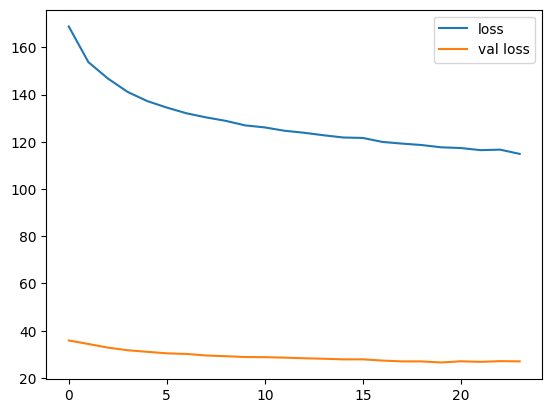

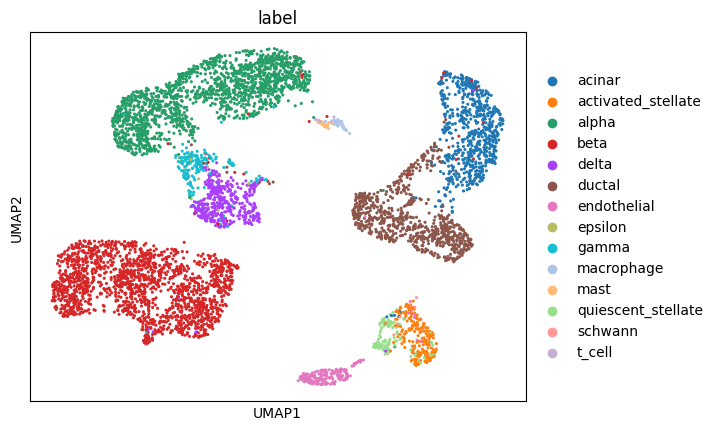

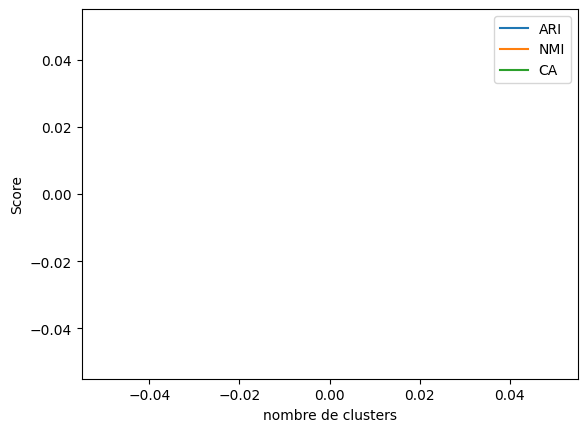

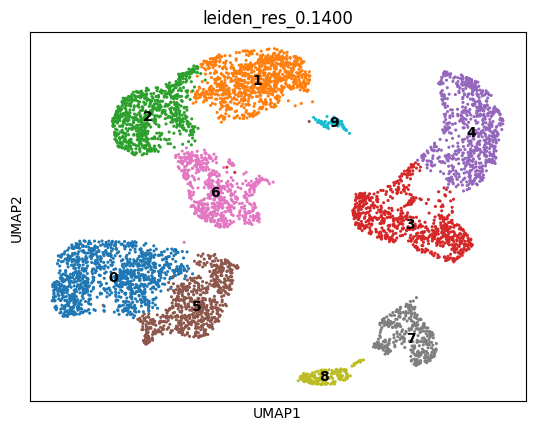

Indice de Rand ajusté (ARI) : 0.6581963992571822
Normalized mutual info (NMI) : 0.815766782540267
Clustering accuracy (CA) : 0.6903967989329777


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_44 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_45 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_23 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 170.78397130966187
ARI 0.30174, NMI: 0.48346, CA : 0.53985, clusters : 4
val_loss : 36.1334810256958
val_ARI 0.31742, val_NMI: 0.48055, val_CA : 0.51751
1). Loss : 154.7474594116211
ARI 0.37478, NMI: 0.56385, CA : 0.5952, clusters : 5
val_loss : 34.88161849975586
val_ARI 0.35705, val_NMI: 0.54233, val_CA : 0.55642
2). Loss : 150.8327751159668
ARI 0.59066, NMI: 0.66514, CA : 0.67806, clusters : 6
val_loss : 33.6531400680542
val_ARI 0.4836, val_NMI: 0.60801, val_CA : 0.64202
3). Loss : 145.3526749610901
ARI 0.74485, NMI: 0.76686, CA : 0.80727, clusters : 5
val_loss : 32.46097111701965
val_ARI 0.67793, val_NMI: 0.72635, val_CA : 0.78755
4). Loss : 139.74317407608032
ARI 0.70274, NMI: 0.75272, CA : 0.72991, clusters : 6
val_loss : 31.405012607574463
val_ARI 0.66833, val_NMI: 0.72139, val_CA : 0.70817
5). Loss : 136.87195253372192
ARI 0.61172, NMI: 0.75207, CA : 0.62771, clusters : 8
val_loss : 30.399516105651855
val_ARI 0.5672, val_NMI: 0.71298, val_CA : 0.58366
6). Loss : 132.9

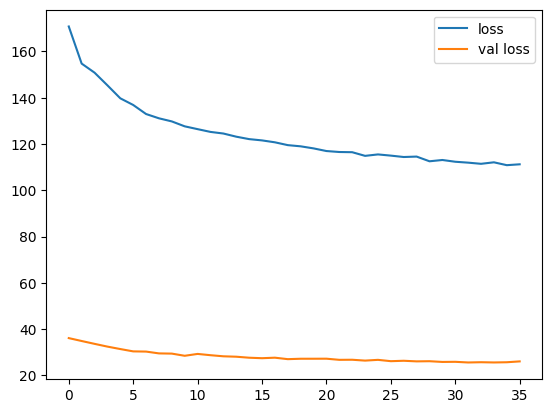

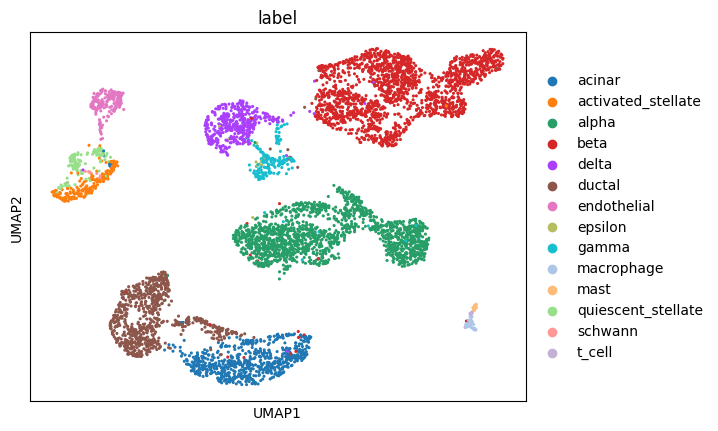

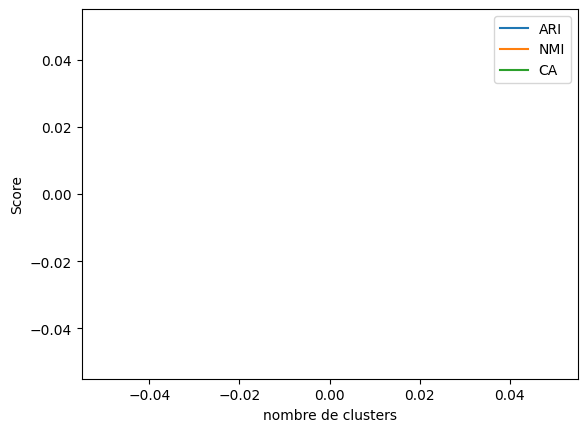

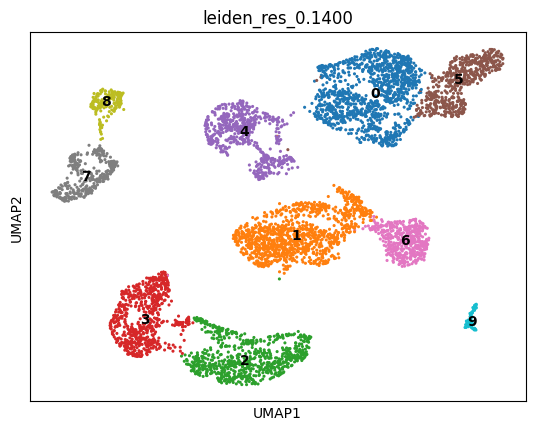

Indice de Rand ajusté (ARI) : 0.6866200891740716
Normalized mutual info (NMI) : 0.8226984363250626
Clustering accuracy (CA) : 0.742914304768256


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_46 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_47 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_24 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 170.9452667236328
ARI 0.34278, NMI: 0.53245, CA : 0.57736, clusters : 5
val_loss : 36.097548484802246
val_ARI 0.32199, val_NMI: 0.51574, val_CA : 0.56576
1). Loss : 154.59231996536255
ARI 0.37325, NMI: 0.57169, CA : 0.56352, clusters : 5
val_loss : 34.6869421005249
val_ARI 0.38225, val_NMI: 0.58932, val_CA : 0.5642
2). Loss : 150.05214548110962
ARI 0.68934, NMI: 0.74501, CA : 0.75559, clusters : 6
val_loss : 33.73419141769409
val_ARI 0.65709, val_NMI: 0.71283, val_CA : 0.73852
3). Loss : 143.03228616714478
ARI 0.75015, NMI: 0.78292, CA : 0.8041, clusters : 6
val_loss : 32.03125858306885
val_ARI 0.72831, val_NMI: 0.75173, val_CA : 0.79377
4). Loss : 138.19560194015503
ARI 0.72566, NMI: 0.77301, CA : 0.78193, clusters : 6
val_loss : 30.97449803352356
val_ARI 0.69823, val_NMI: 0.75429, val_CA : 0.76342
5). Loss : 135.83748960494995
ARI 0.70083, NMI: 0.76264, CA : 0.75759, clusters : 6
val_loss : 30.625293731689453
val_ARI 0.72211, val_NMI: 0.76047, val_CA : 0.78599
6). Loss : 1

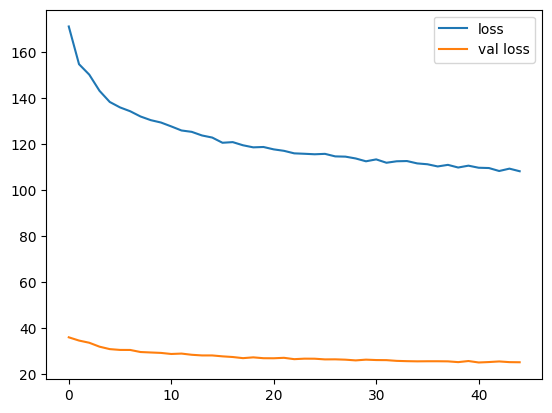

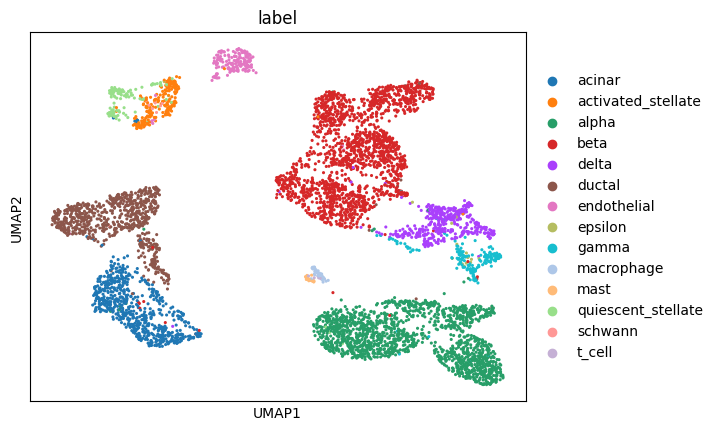

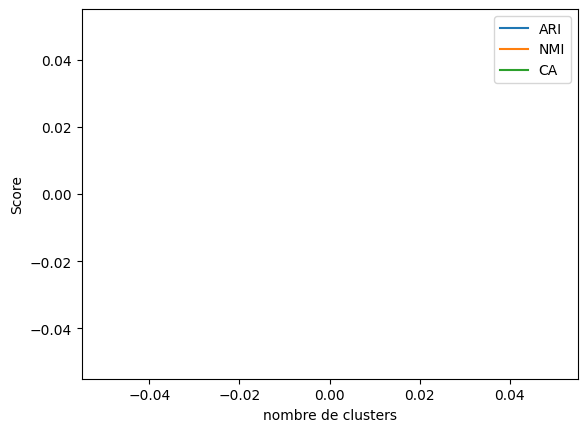

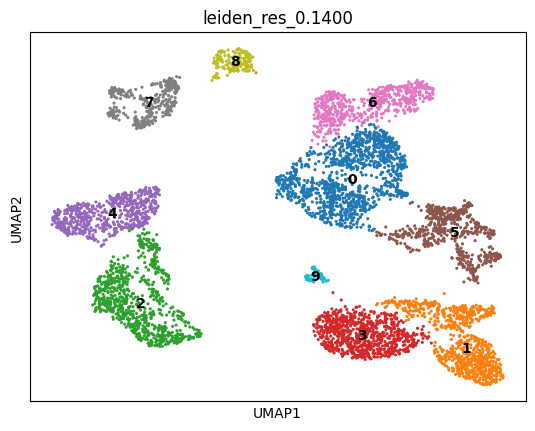

Indice de Rand ajusté (ARI) : 0.6506813626568968
Normalized mutual info (NMI) : 0.8091976441310685
Clustering accuracy (CA) : 0.6810603534511503


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 200)            │       400,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_48 (ReLU)                 │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 40)             │         8,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_49 (ReLU)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_25 (Lambda)              │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,660 (1.57 MB)

 Trainable params: 411,180 (1.57 MB)

 Non-trainable params: 480 (1.88 KB)

0). Loss : 171.0885305404663
ARI 0.31765, NMI: 0.49446, CA : 0.56952, clusters : 4
val_loss : 36.212215423583984
val_ARI 0.32961, val_NMI: 0.48689, val_CA : 0.53463
1). Loss : 154.84329319000244
ARI 0.67031, NMI: 0.68102, CA : 0.76576, clusters : 4
val_loss : 34.61811017990112
val_ARI 0.58106, val_NMI: 0.63795, val_CA : 0.7323
2). Loss : 148.64671897888184
ARI 0.77266, NMI: 0.78234, CA : 0.81561, clusters : 5
val_loss : 33.253862380981445
val_ARI 0.75858, val_NMI: 0.74935, val_CA : 0.80778
3). Loss : 142.09348964691162
ARI 0.67935, NMI: 0.74869, CA : 0.72658, clusters : 6
val_loss : 31.919505834579468
val_ARI 0.67896, val_NMI: 0.72981, val_CA : 0.74319
4). Loss : 138.261070728302
ARI 0.68644, NMI: 0.75782, CA : 0.74225, clusters : 6
val_loss : 31.60773253440857
val_ARI 0.67233, val_NMI: 0.72236, val_CA : 0.74553
5). Loss : 136.2714385986328
ARI 0.89327, NMI: 0.84462, CA : 0.87462, clusters : 6
val_loss : 30.6009361743927
val_ARI 0.80398, val_NMI: 0.79127, val_CA : 0.82179
6). Loss : 13

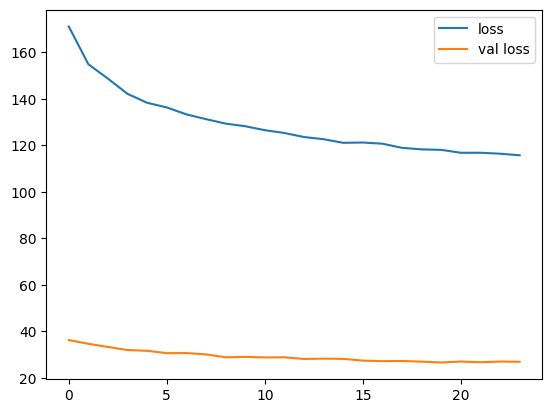

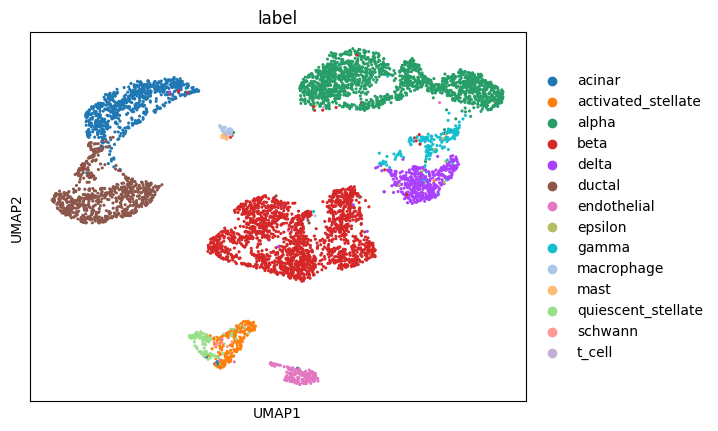

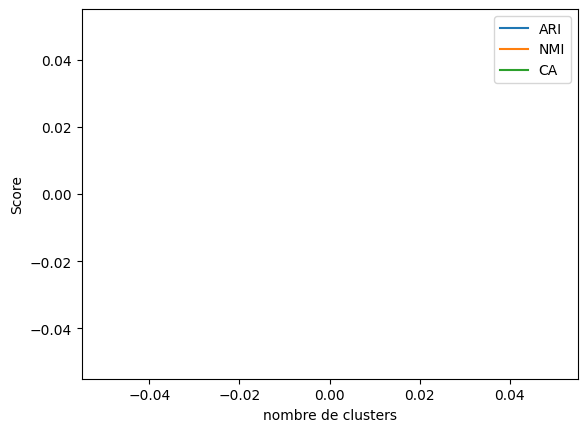

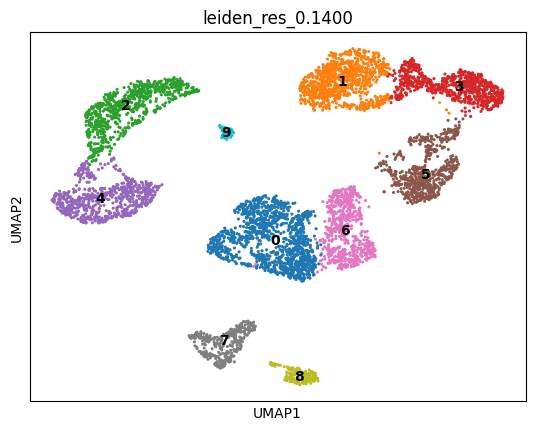

Indice de Rand ajusté (ARI) : 0.6649661546234982
Normalized mutual info (NMI) : 0.817238450362724
Clustering accuracy (CA) : 0.7024008002667556


In [31]:
for res in range (10,15):
    for i in range (5):
        model, results=train_model(x_train, Y=y_train, n='auto', res=res/100, nb_epochs=200, lr=0.4, 
                temperature=0.07, dropout=0.9, evaluate_training=True,  eval_interval=1, 
                layers=[200, 40, 60], save=True, noise=0, method='leiden', batch_size=200, 
               X_test=x_val, Y_test=y_val, early_stopping=True, plot_loss=True)